In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Rectangle
import seaborn as sns
sns.set_context('notebook')
import itertools
from scipy.integrate import solve_ivp, RK45, DOP853, LSODA, Radau, BDF
import gc
from scipy.stats import poisson
from scipy import stats

# Reaction Network Model

In [2]:
class MacroState:
    def __init__(self, origin, extent):
        """ Pass origin and extent as a tuple. """
        assert len(origin) == len(extent)

        self.origin = np.array(origin)
        self.extent = np.array(extent)
    
    @property
    def dim(self):
        return len(self.origin)
    
    @property
    def volume(self):
        return np.prod(self.extent)
    
    @property
    def is_empty(self):
        return np.any(self.extent == 0)
    
    def iter_micro_states(self):
        return itertools.product(*[range(oi, oi + ei)
                                   for oi, ei in zip(self.origin, self.extent)])

    def intersection(self, other):
        origin = np.maximum(self.origin, other.origin)
        extent = np.maximum(
            np.minimum(
                self.origin + self.extent,
                other.origin + other.extent) - origin,
            0)
        
        return MacroState(origin, extent)
    
    def cover(self, other):
        """ --- No strict set union! ---
        This method constructs the smalles surrounding box.
        """
        origin = np.minimum(self.origin, other.origin)
        extent = np.maximum(self.origin + self.extent, other.origin + other.extent) - origin
        
        return MacroState(tuple(origin), tuple(extent))
    
    def subtract(self, other):
        # Algorithm idea: Shrink `self` in each dimension and direction. Each shrinking results
        #     in a MacroState. Terminate if `self` is exactly other (after `2 * dim` iterations).
        #     The collection of MacroStates resulting from shrinking give the difference.
        difference = list()
        uncovered = self.copy()
        if uncovered.intersection(other).is_empty:
            return [uncovered]
        for direction in range(self.dim):
            # bottom
            ext_dir = other.origin[direction] - uncovered.origin[direction]
            if ext_dir > 0:
                extent = np.copy(uncovered.extent)
                extent[direction] = ext_dir
                difference.append(MacroState(np.copy(uncovered.origin), extent))
                uncovered.origin[direction] += ext_dir
                uncovered.extent[direction] -= ext_dir
                
            if uncovered.is_empty:
                break
            
            # top
            orig_dir = max(other.origin[direction] + other.extent[direction], uncovered.origin[direction])
            ext_dir = uncovered.origin[direction] + uncovered.extent[direction] - orig_dir
            if ext_dir > 0:
                origin = np.copy(uncovered.origin)
                origin[direction] = orig_dir
                extent = np.copy(uncovered.extent)
                extent[direction] = ext_dir
                difference.append(MacroState(origin, extent))
                uncovered.extent[direction] -= ext_dir
            
            if uncovered.is_empty:
                break
            
            # early termination check
            # TODO: is this even an optimization?
        assert uncovered.is_empty or uncovered in other, uncovered
        assert all(b in self for b in difference), list((b, b in self) for b in difference)
        assert all(b.intersection(other).is_empty for b in difference)
        return difference
                
    def translate(self, v):
        v = np.atleast_1d(v)
        return MacroState(self.origin + v, self.extent)
    
    def split(self, ax, k):
        k = int(np.ceil(self.extent[ax] / 2)) if k is None else min(k, self.extent[ax])
        origin2 = np.copy(self.origin)
        origin2[ax] += k
        extent2 = np.copy(self.extent)
        extent2[ax] -= k
        self.extent[ax] = k
        return MacroState(self.origin, self.extent), MacroState(origin2, extent2)
    
    def copy(self):
        return MacroState(self.origin, self.extent)
        
    def __contains__(self, key):
        if key.dim != self.dim:
            return False
        return self.cover(key) == self
        
    def __hash__(self):
        return sum(x * 13 ** i for i, x in enumerate(itertools.chain(self.origin, self.extent)))
    
    def __eq__(self, other):
        if isinstance(other, self.__class__):
            return np.all(self.origin == other.origin) and np.all(self.extent == other.extent)
        else:
            return False

    def __ne__(self, other):
        return not self.__eq__(other)
    
    def __repr__(self):
        return "Box@{}->{}".format(self.origin, self.extent)

In [3]:
class CRN:
    def __init__(self, v_educt, v_product, prop_funs, prop_integrals=None):
        """ The matrices `v_educt` and `v_product` have shape `(n_reactions, n_dim)`. """
        self.v_educt = np.atleast_2d(v_educt)
        self.v_product = np.atleast_2d(v_product)
        assert self.v_educt.shape == self.v_product.shape
        self.stoich = self.v_product - self.v_educt
        self.prop_funs = prop_funs
        self.prop_integrals = prop_integrals
            
    @property
    def dim(self):
        return self.stoich.shape[1]
    
    @property
    def n_reactions(self):
        return self.stoich.shape[0]
    
    def prop_vec(self, state):
        return np.array([self.prop(i, state) for i in range(self.n_reactions)])
    
    def prop(self, reaction_idx, state):
        return self.prop_funs[reaction_idx](state)
    
    def prop_integral(self, reaction_idx, macro_state):
        if self.prop_integrals is None:
            return sum(self.prop(reaction_idx, x) for x in macro_state.iter_micro_states())
        else:
            return self.prop_integrals[reaction_idx](macro_state)

In [4]:
def faulhaber(hi, exp):
    if exp == 0:
        return hi
    elif exp == 1:
        return (hi ** 2 + hi) / 2
    elif exp == 2:
        return hi ** 3 / 3 + hi ** 2 / 2 + hi / 6
    elif exp == 3:
        return hi ** 4 / 4 + hi ** 3 / 2 + hi ** 2 / 4
    else:
        raise NotImplementedError()

def faulhaber_int(lo, hi, exp):
    return int(faulhaber(hi, exp) - faulhaber(lo - 1, exp))

In [5]:
class NonFaulMassActionCRN(CRN):
    def __init__(self, v_educt, v_product, props):
        self.props = props
        super(NonFaulMassActionCRN, self).__init__(v_educt, v_product, prop_funs=None)
        
    def prop(self, reaction_idx, state):
        return self.props[reaction_idx] * np.prod(
            [np.prod([state[i] - x
                      for x in range(self.v_educt[reaction_idx][i])])
             for i in range(self.dim)])

In [6]:
class MassActionCRN(CRN):
    def __init__(self, v_educt, v_product, props):
        self.props = props
        super(MassActionCRN, self).__init__(v_educt, v_product, prop_funs=None)
        
    def prop(self, reaction_idx, state):
        return self.props[reaction_idx] * np.prod(
            [np.prod([state[i] - x
                      for x in range(self.v_educt[reaction_idx][i])])
             for i in range(self.dim)])
    
    def prop_integral(self, reaction_idx, macro_state):
        v_in = self.v_educt[reaction_idx]
        coeff = self.props[reaction_idx]
        rvol = lambda ms, bl: np.prod([ms.extent[k] for k in range(ms.dim)
                                      if k not in bl])
        if v_in.sum() == 0:
            return coeff * macro_state.volume
        elif v_in.sum() == 1:
            i = np.where(v_in != 0)[0][0]
            oi = macro_state.origin[i]
            ei = oi + macro_state.extent[i]
            return coeff * faulhaber_int(oi, ei - 1, 1) * rvol(macro_state, [i])
        elif v_in.sum() == 2:
            if v_in.max() == 1:
                i, j = np.where(v_in != 0)[0]
                oi, oj = macro_state.origin[i], macro_state.origin[j]
                ei, ej = oi + macro_state.extent[i], oj + macro_state.extent[j]
                return (coeff * faulhaber_int(oi, ei - 1, 1)
                        * faulhaber_int(oj, ej - 1, 1) * rvol(macro_state, [i, j]))
            else:
                i = np.where(v_in != 0)[0][0]
                oi = macro_state.origin[i]
                ei = oi + macro_state.extent[i]
                return coeff / 2 * (faulhaber_int(oi, ei - 1, 2)
                                    + faulhaber_int(oi, ei - 1, 1)) * rvol(macro_state, [i])
        else:
            raise NotImplementedError()

# Stochastic Simulation

In [52]:
def sim(model, T, s0):
    s = np.copy(s0)
    t = 0
    r_idcs = np.arange(model.n_reactions)

    times = [0]
    states = [np.copy(s)]

    while t < T:
        rates = model.prop_vec(s)
        rate0 = rates.sum()
        if rate0 == 0:
            times.append(T)
            states.append(np.copy(s))
            break
        t += np.random.exponential(1 / rate0)
        try:
            j = np.random.choice(r_idcs, p=rates/rate0)
        except:
            print(j, rates)
            print()
        s += model.stoich[j]

        times.append(t)
        states.append(np.copy(s))

    states = np.array(states)
    return times, states

def sim_up_to(model, T, s0):
    s = np.copy(s0)
    t = 0
    r_idcs = np.arange(model.n_reactions)

    while t < T:
        rates = model.prop_vec(s)
        rate0 = rates.sum()
        if rate0 == 0:
            return s
        t += np.random.exponential(1 / rate0)
        try:
            j = np.random.choice(r_idcs, p=rates/rate0)
        except:
            print(j, rates)
            print()
        s += model.stoich[j]

    return s

# State-Space Model and Semantics

In [7]:
class QMatrix(object):
    def __init__(self, data, has_sink, size=None):
        self._data = data
        self._has_sink = has_sink
        self._size = data.shape[0] if size is None else size
    
    @property
    def has_sink(self):
        return self._has_sink

    @property
    def data(self):
        return self._data[:self._size, :self._size]
    
    @property
    def size(self):
        return self._size
    
    def add_sink(self):
        self.extend(by=1)
        self._data[1:,1:] = self._data[:-1,:-1]
        self._data[0,:] = 0
        self._data[:,0] = 0
        self._has_sink = True

    def extend(self, by=1):
        if len(self._data) < self._size + by:
            new_data = np.zeros((int(len(self._data) * 2),) * 2)
            new_data[:self._size,:self._size] = self._data
            self._data = new_data
        self._size += by
    
    def remove(self, pos):
        rm_pos = np.unique(np.atleast_1d(pos))
        keep_pos = np.array([i for i in range(len(self)) if i not in rm_pos])
        new_size = len(keep_pos)
        self._data[:new_size,:new_size] = self._data[keep_pos].T[keep_pos].T
        self._data[new_size:self._size,new_size:self._size] = 0
        self._size = new_size
        
    def copy(self):
        return QMatrix(np.copy(self._data), self.has_sink, size=size)
        
    def __len__(self):
        return self.size

In [8]:
class StateSpace:
    def __init__(self, states, model, sink=False, q_matrix=None):
        """ Pass in a valid state space tessalation as a list via `states` and
        a model of class `CRN`. """
        self.has_sink = False
        self.states = states
        self.model = model
        self._sinks = dict()
        self.q_matrix = QMatrix(self._init_q_matrix(), False) if q_matrix is None else q_matrix
        self._set_q_diagonal()
        if sink:
            self.add_sink_state()
            for i in range(len(self)):
                self._connect_sink(i)
        self._set_q_diagonal()
        self.check_sanity()
    
    def _init_q_matrix(self):
        q = np.zeros((len(self.states),) * 2)
        for i1, i2 in itertools.product(*[range(len(self)), range(len(self))]):
            q[i1, i2] += self._flow(i1, i2)
        return q
    
    def _connect_sink(self, i):
        assert self.has_sink
        if i == 0:
            return
        rate0 = sum(self._outflow(self.states[i], j) for j in range(self.model.n_reactions))
        outflow = rate0 + self.q_matrix.data[i, i]
        outflow = 0 if outflow < 1e-15 else outflow
        self.q_matrix.data[i, 0] = outflow
            
    def _split_dist(self, distribution, i1, i2):
        new_shape = list(distribution.shape)
        new_shape[0] += 1
        new_dist = np.zeros(new_shape)
        new_dist[:i2] = distribution
        new_dist[i1] /= 2
        new_dist[i2] = new_dist[i1]
        return new_dist
        
    def _connect(self, i, ns):
        """ Does not connect sink `if 0 in ns` and `has_sink == True`. """
        for n in ns:
            if n == i or (n == 0 and self.has_sink):
                continue
            self.q_matrix.data[i, n] += self._flow(i, n)
            self.q_matrix.data[n, i] += self._flow(n, i)
    
    def _set_q_diagonal(self):
        idcs = np.diag_indices_from(self.q_matrix.data)
        self.q_matrix.data[idcs] = 0
        self.q_matrix.data[idcs] -= self.q_matrix.data.sum(1)

    def _flow(self, i1, i2):
        if i1 == i2:
            return 0
        flow = 0
        for j in range(self.model.n_reactions):
            b1, b2 = self.states[i1], self.states[i2]
            flow += self._flow_from_state(b1, b2, j)
        return flow
        
    def _flow_from_state(self, b1, b2, j):
        b_transition = (b1.translate(self.model.stoich[j])
                        .intersection(b2)
                        .translate(-self.model.stoich[j]))
        rate = self.model.prop_integral(j, b_transition)
        return rate / b1.volume  # (b_transition.volume / b1.volume)
    
    def _outflow(self, b, j):
        b_transitions = [bi.translate(-self.model.stoich[j]) for bi in
                         b.translate(self.model.stoich[j]).subtract(b)]
        if len(b_transitions) == 0:
            return 0
        rate = sum(self.model.prop_integral(j, bi) for bi in b_transitions)
        return  rate / b.volume

    def _connect_all(self, idcs, neighbors, connect2sink):
        # connect new states
        for i1, i2 in itertools.product(idcs, idcs):
            if i1 == 0 or i2 == 0:
                continue
            self.q_matrix.data[i1, i2] += self._flow(i1, i2)
        for i in idcs:
            self._connect(i, neighbors)
        self._set_q_diagonal()
        # connect sink state
        if connect2sink:
            for i in idcs:
                self._connect_sink(i)
    
    def _disconnect(self, idcs):
        self.q_matrix.data[idcs] = 0
        self.q_matrix.data[:,idcs] = 0
        
    def _split_once(self, i, ax, k=None):
        b1, b2 = self.states[i].split(ax, k)
        self.q_matrix.extend(by=1)
        i1, i2 = i, len(self)
        self.states.append(b2)
        self.states[i1] = b1
        return i2
    
    def redirect_sink_uniform(self):
        """ Remove sink and redirect incoming transitions uniformly to all other states. """
        assert self.has_sink
        incoming = self.q_matrix[1:, 0]
        self.remove(0, redirect2sink=False)
        self.q_matrix += np.outer(incoming, np.ones(len(self))) / len(self)
        self._set_q_diagonal()
        self.has_sink = False
    
    def stationary_distribution(self):
        a = np.copy(self.q_matrix.T)
        a[0] = 1
        b = np.zeros(len(self))
        b[0] = 1
        return np.linalg.solve(a, b)
    
    def make_absorbing(self, idx):
        self._sinks[idx] = np.copy(self.q_matrix.data[idx])
        self.q_matrix.data[idx] = 0
        
    def undo_absorbing(self, idx):
        self.q_matrix.data[idx] = self._sinks[idx]
        del self._sinks[idx]
    
    def add_sink_state(self):
        if self.has_sink:
            return
        self.states = [MacroState((-10,) * self.model.dim, (1,) * self.model.dim)] + self.states
        self.q_matrix.add_sink()
        self.has_sink = True
        
    def remove(self, idcs, redirect2sink=False):
        assert not redirect2sink or self.has_sink
        idcs = np.atleast_1d(idcs)
        if len(idcs) == 0:
            return
        idcs[::-1].sort()
        for i in idcs:
            assert i < len(self), (i, len(self))
            del self.states[i]
        if redirect2sink:
            redirected_mass = self.q_matrix.data.T[idcs].sum(0)
            redirected_mass[idcs] = 0
            self.q_matrix.data[:,0] += redirected_mass
        self.q_matrix.remove(idcs)
        self._set_q_diagonal()
    
    def check_sanity(self):
        assert len(self) == len(self.q_matrix)
        assert self.has_sink == self.q_matrix.has_sink
#         for i1 in range(len(self)):
#             for i2 in range(i1):
#                 assert self.states[i1].intersection(self.states[i2]).volume == 0, (self.states[i1], self.states[i2])
    
    def neighbors(self, i):
        neighbors = (self.q_matrix.data[i] != 0) | (self.q_matrix.data[:,i] != 0)
        neighbors[i] = False
        return np.where(neighbors)[0]
    
    def split(self, i, axes, k=None):
        if i == 0 and self.has_sink:
            return
        
        ns = self.neighbors(i)
        connected2sink = self.q_matrix.data[i, 0] > 0
        # construct new states
        new_states = list()
        axes = np.atleast_1d(axes)
        splits = [i]
        for ax in axes:
            next_splits = list()
            for i in splits:
                next_splits.append(i)
                next_splits.append(self._split_once(i, ax))
            new_states.extend(next_splits)
            splits = next_splits
        new_states = np.unique(new_states)
        self._disconnect(new_states)
        self._connect_all(new_states, ns, connected2sink)
        
        self._set_q_diagonal()
        return new_states
            
    def split_w_dist(self, i, axes, distribution, k=None):
        new_states = self.split(i, axes, k=k)
        new_shape = list(distribution.shape)
        new_shape[0] = len(self)
        new_dist = np.zeros(tuple(new_shape))
        new_dist[:len(distribution)] = distribution
        new_dist[new_states] = distribution[i] / len(new_states)
        return new_dist
    
    def entropy(self, distribution):
        assert len(self) == len(distribution)
        return - sum(p * np.log2(p) * x.volume
                     for p, x in zip(distribution, self.states)
                     if p > 0)
    
    def copy(self):
        cpy = StateSpace([s.copy() for s in self.states],
                         self.model, q_matrix=self.q_matrix.copy())
        cpy.has_sink = self.has_sink
        return cpy
    
    def __len__(self):
        return len(self.states)

In [9]:
def plot_2d_dist(ax, states, probs, xlim=None, ylim=None):
    dist = np.array([(p / b.volume) for p, b in zip(probs, states)])
    dist += np.abs(dist.min())
    dist /= dist.max()
    dist *= 255
    dist = dist.astype(np.int)
    for i, box in enumerate(states):
        color = plt.get_cmap('viridis').colors[int(dist[i])]
        patch = Rectangle(box.origin, box.extent[0], box.extent[1],
                          facecolor=color,
                          lw=.0, edgecolor='k', fill=True
                         )
        ax.add_patch(patch)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

# Birth-Death Model
#### Finite-State-Projection

In [10]:
model = MassActionCRN(np.array([[0], [1]]), np.array([[1], [0]]), np.array([10, .1]))
n = 200
states = [MacroState((x,), (1,)) for x in range(n)]# + [MacroState((n,), (np.Inf,))]
ss = StateSpace(states, model, sink=True)
t_eval = np.linspace(0, 50, 500)

y0 = np.array([0] + [1] + [0] * (n - 1))
fun = lambda t, y: y @ ss.q_matrix.data
res1 = solve_ivp(fun, (0,50), y0, t_eval=t_eval, atol=1e-10, rtol=1e-10)

#### Lumped Version (5-State Scheme)

In [11]:
model = MassActionCRN(np.array([[0], [1]]), np.array([[1], [0]]), np.array([10, .1]))
mss = 5
n = int(200 / mss)
states = [MacroState((x * mss,), (mss,)) for x in range(n)]# + [MacroState((n,), (np.Inf,))]
ss = StateSpace(states, model, sink=True)

y0 = np.array([0] + [1] + [0] * (n - 1))
fun = lambda t, y: y @ ss.q_matrix.data
res2 = solve_ivp(fun, (0, 50), y0, t_eval=t_eval, atol=1e-10, rtol=1e-10)

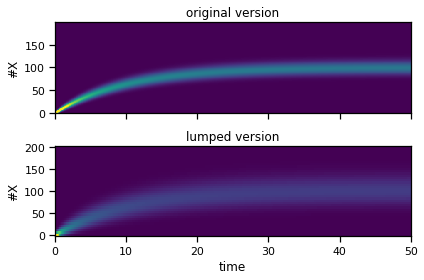

In [12]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(6, 4))
ax1.imshow(res1.y[1:,:], vmax=.1, origin='lower', aspect='auto', interpolation='none')
ax1.set_title('original version')
ax1.set_xticks(np.arange(0, 501, 100))
ax1.set_ylabel('#X')
ax1.tick_params(labelbottom=False)   
ax2.imshow(res2.y[1:,:], vmax=.1*mss, origin='lower', aspect='auto', interpolation='none')
ax2.set_title('lumped version')
ax2.set_xticks(np.arange(0, 501, 100)); ax2.set_xticklabels(range(0, 51, 10))
ax2.set_yticks(np.linspace(0, 39, 5)); ax2.set_yticklabels(labels=np.arange(0, 201, 50))
ax2.set_ylabel('#X')
ax2.set_xlabel('time')
plt.tight_layout()
plt.savefig('lumpedvorig.pdf')

## Comparison of Terminal Distribution

Original mass: 0.999999999999998
Lumped mass: 1.0000000000000002


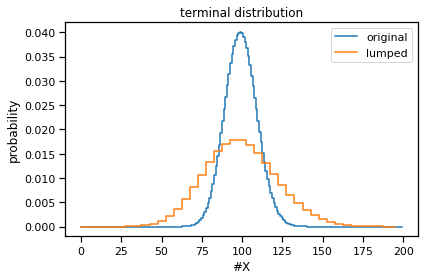

In [13]:
fig = plt.figure(figsize=(6,4))
plt.step(range(0, 200), res1.y.T[-1][1:], label='original', where='mid')
lumpplot = list(range(0, n * mss, mss)), res2.y.T[-1][1:] / mss
plt.step(lumpplot[0], lumpplot[1], label='lumped', where='mid')
plt.legend()
plt.ylabel('probability')
plt.xlabel('#X')
plt.title('terminal distribution')
print('Original mass:', res1.y.T[-1].sum())
print('Lumped mass:', res2.y.T[-1].sum())
plt.tight_layout()
plt.savefig('lumped_dist.pdf')

# Lumped Integration

In [14]:
class LumpingCMEIntegrator:
    def __init__(self, model, ss, y0, split_thres, t0=0, t_max=np.inf, checks=False, max_step=1e-1):
        assert len(y0) == len(ss)
        assert split_thres > 0
        
        self.model = model
        self.ss = ss
        self.t = t0
        self.t0 = t0
        self.t_max = t_max
        self.y = y0
        self.split_thres = split_thres
        self._invalidate_integrator_state()
        self._sanity_checks = checks
        self._forward = True
        self._max_step=max_step
    
    @property
    def has_sink(self):
        """ The sink state, if present, is always located at 0. """
        return self.ss.has_sink
    
    @property
    def dy(self):
        if self._dy is None:
            self._dy = self.integrator.fun(self.t, self.y)
        return self._dy
    
    @property
    def integrator(self):
        if not self._integrator_valid:
            if self.is_forward:
                fun = lambda t, y: y @ self.ss.q_matrix.data
            else:
                fun = lambda t, y: self.ss.q_matrix.data @ y
            self._integrator = BDF(fun, self.t, self.y, self.t_max, # rtol=1e-5, atol=1e-7,
                                   rtol=1e-10, atol=1e-12,
                                   max_step=self._max_step)
#             self._integrator = RK45(fun, self.t, self.y, self.t_max, atol=1e-15, rtol=1e-12)
#             self._integrator = LSODA(fun, self.t, self.y, self.t_max, atol=1e-15, rtol=1e-12)
            self._dy = None
            self._integrator_valid = True
        return self._integrator
    
    @property
    def is_forward(self):
        return self._forward
    
    def _invalidate_integrator_state(self):
        self._integrator_valid = False
        self._integrator = None
        self._dy = None
        
    def check_sanity(self):
        if self._sanity_checks:
            self.ss.check_sanity()
            assert len(self.ss) == len(self.y)
    
    def make_absorbing(self, idx):
        self.ss.make_absorbing(idx)
        self._invalidate_integrator_state()
        
    def undo_absorbing(self, idx):
        self.ss.undo_absorbing(idx)
        self._invalidate_integrator_state()
    
    def add_sink_state(self):
        if self.has_sink:
            return
        self.ss.add_sink_state()
        y_new = np.zeros(len(self.y) + 1)
        y_new[1:] = self.y
        self.y = y_new
        assert len(self.y) == len(self.ss)
        
    def remove_sink_state(self):
        if not self.has_sink:
            return
        self.ss.remove_sink_state()
        y_new = np.zeros(len(self.y) - 1)
        y_new = self.y[1:]
        y_new += self.y[0]
        self.y = y_new
        assert len(self.y) == len(self.ss)
    
    def remove(self, idcs, redirect2sink=False):
        assert not redirect2sink or self.has_sink
        if len(np.atleast_1d(idcs)) == 0:
            return
        self.y = np.delete(self.y, idcs, axis=0)
        self.ss.remove(idcs, redirect2sink=redirect2sink)
        self._invalidate_integrator_state()
    
    def switch_direction(self):
        self.t, self.t_max = self.t0, self.t_max
        self._forward = not self._forward
        self._invalidate_integrator_state()
    
    def step(self):
        self.check_sanity()
        self.integrator.step()
        self.t = self.integrator.t
        self.y = self.integrator.y
        if hasattr(self.integrator, 'f'):
            self._dy = self.integrator.f
        else:
            self._dy = None
        
    def plot(self):
        fig, (ax1, ax2) = plt.subplots(2, figsize=(10, 7))
        idcs = np.argsort([b.origin[0] for b in self.ss.states])
        ms = np.cumsum([0] + [b.extent[0] for b in np.take(self.ss.states, idcs)])
        
        ax1.step(ms, [self.y[0]] + list(np.take(self.y, idcs)))
        sns.rugplot(ms, ax=ax1)
        ax2.step(ms, [0] + list(np.take(self.dy, idcs)))
        
    def split_criterion(self, criterion_dist=None):
        dist = self.y + np.abs(self.dy) if criterion_dist is None else criterion_dist

        return dist

    def split_states(self, criterion_dist=None, blacklist=[], min_volume=2):
        splits = np.where(self.split_criterion(criterion_dist) > self.split_thres)[0]
        splits = [split for split in splits if self.ss.states[split].volume >= min_volume]
        change = False
        for ax in range(self.model.dim):
            next_splits = list()
            for split in splits:
                if split in blacklist:
                    continue
                if self.ss.states[split].volume < 1:
                    continue
                next_splits.append(split)
                if self.ss.states[split].extent[ax] <= 1:
                    continue
                self.y = self.ss.split_w_dist(split, ax, self.y)
                next_splits.append(len(self.y) - 1)  # split new states in other dimensions
                change = True
            splits = next_splits
        self._invalidate_integrator_state()
        
        return change

    
    def __len__(self):
        return len(self.ss)

## Figure 1

In [15]:
n = 100

model = MassActionCRN(np.array([[0], [1]]), np.array([[1], [0]]), np.array([10, .1]))
states = [MacroState((x,), (1,)) for x in range(n)]
ss = StateSpace(states, model)

t0 = 0
t_max = 10
y = np.array([1] + [0] * (len(ss) - 1))
t = t0


integrator = LumpingCMEIntegrator(model, ss, y, 1e-4, 0, t_max)

granularity = 500
forward  = np.zeros((granularity, len(ss)))
backward = np.zeros((granularity, len(ss)))
dists    = np.vstack([forward, backward])
dt = t_max / granularity
t_log = t
tgt_idx = 40

# forward integration
print('-> Forwards integration')
steps = 0
while integrator.t < t_max:
    integrator.step()
    
    # Logging
    while integrator.t > t_log:
        dists[steps] = integrator.y
        t_log = round(t_log + dt, 2)
        steps += 1

        
# backward integration
print('-> Backwards integration')
integrator.switch_direction()
y = np.zeros(len(ss))
y[tgt_idx] = 1
integrator.y = y
t_log = 0
while integrator.t < t_max:
    integrator.step()
    
    # Logging
    while integrator.t > t_log:
        dists[granularity + steps - 1] = integrator.y
        t_log = round(t_log + dt, 2)
        steps -= 1

#     integrator.split_states()

-> Forwards integration
-> Backwards integration


In [16]:
fw = dists[:granularity].T
bw = dists[granularity:].T
bridge = bw * fw

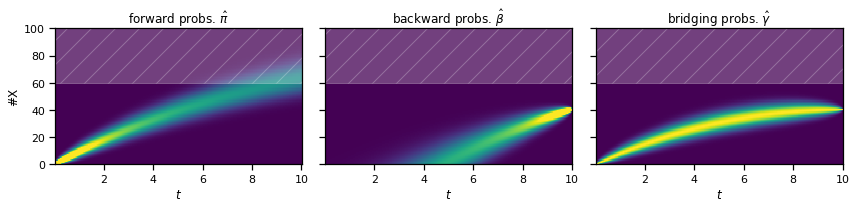

In [17]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(12, 3), ncols=3)

ax1.imshow(fw , vmax=.1, origin='lower', aspect='auto', interpolation='none')
ax1.set_ylabel('#X')
ax2.imshow(bw , vmax=.1, origin='lower', aspect='auto', interpolation='none')
ax2.tick_params(labelleft=False)
ax3.imshow(bridge / bridge.max(0), origin='lower', aspect='auto', interpolation='none')
ax3.tick_params(labelleft=False)
for ax in [ax1, ax2, ax3]:
    ax.set_xlabel('$t$')
    ax.set_xticks(np.arange(0, granularity + 1, granularity/5) - .5)
    ax.set_xticklabels(np.linspace(0, 10, 6).astype(np.int))
ax1.set_title(r'forward probs. $\hat\pi$')
ax2.set_title(r'backward probs. $\hat\beta$')
ax3.set_title(r'bridging probs. $\hat\gamma$')
for ax in [ax1, ax2, ax3]:
    ax.fill_between([0, granularity], [60] * 2, [100] * 2, hatch='/', zorder=1, alpha=.25, color='w')
    ax.set_ylim(0, 100)
    ax.set_xlim(0, granularity)

plt.tight_layout()
plt.savefig('bridging_bd.pdf')

# Bridging Problem

In [18]:
print('-> Setting up integration')
par_bd = MassActionCRN(
    np.array([[0, 0], [1, 0], [0, 0], [0, 1]]),
    np.array([[1, 0], [0, 0], [0, 1], [0, 0]]),
    np.array([10, .1, 10, .1]))
step = 32
states = [MacroState((x1, x2), (step, step))
          for x1, x2 in itertools.product(range(0, step * 15, step), range(0, step * 15, step))]

ss = StateSpace(states, par_bd, sink=True)
# for i in range(len(ss)):
#     ss.split(i, [0,1])

-> Setting up integration


In [19]:
n = 10
n_max = 500

t0 = 0
t_max = 10
y = np.zeros(len(ss))
y[1] = 1
t = t0

integrator = LumpingCMEIntegrator(par_bd, ss, y, 1e-4, 0, t_max)

granularity = 10
forward  = np.zeros((granularity, len(ss)))
backward = np.zeros((granularity, len(ss)))
dists    = np.vstack([forward, backward])
dt = t_max / granularity
t_log = t
tgt_idx = 100

integrator.make_absorbing(tgt_idx)

# forward integration
print('-> Forwards integration')
steps = 0
while integrator.t < t_max:
    integrator.step()
    
    # Logging
    while integrator.t > t_log:
        dists[steps] = integrator.y
        t_log = round(t_log + dt, 2)
        steps += 1

        
# backward integration
print('-> Backwards integration')
integrator.switch_direction()
y = np.zeros(len(ss))
y[tgt_idx] = 1
integrator.y = y
t_log = 0
while integrator.t < t_max:
    integrator.step()
    
    # Logging
    while integrator.t > t_log:
        dists[granularity + steps - 1] = integrator.y
        t_log = round(t_log + dt, 2)
        steps -= 1

#     integrator.split_states()

-> Forwards integration
-> Backwards integration


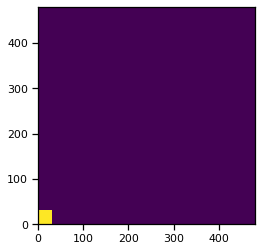

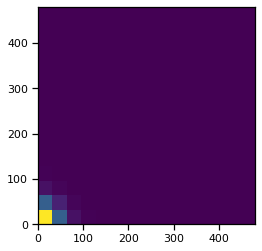

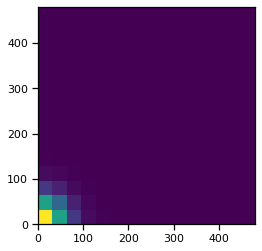

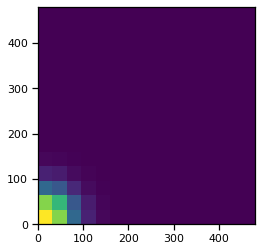

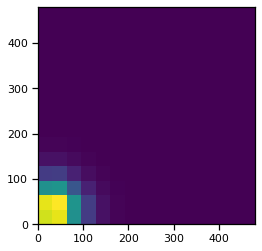

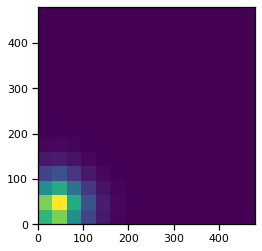

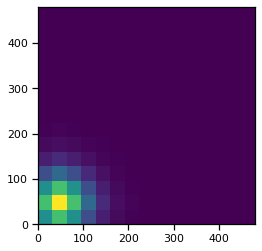

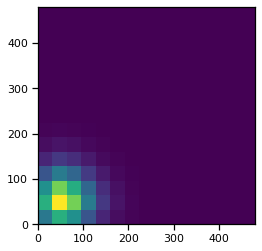

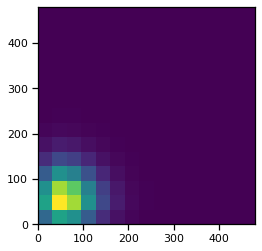

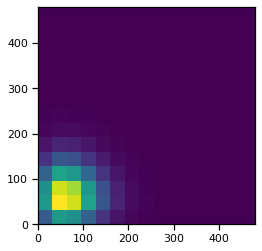

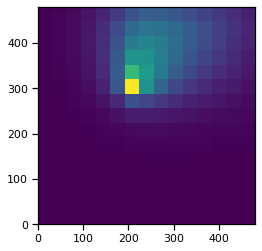

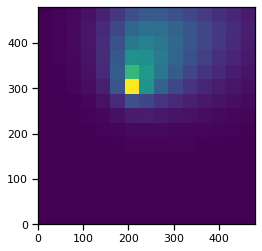

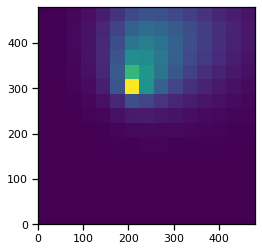

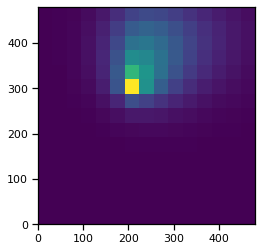

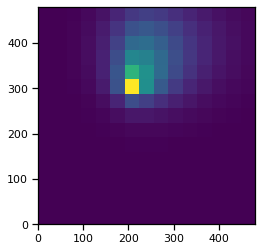

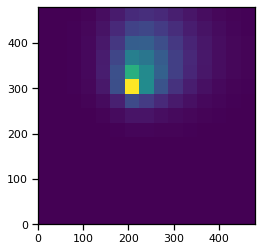

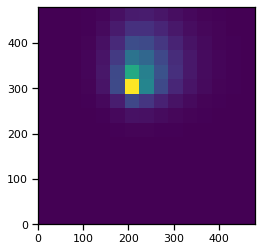

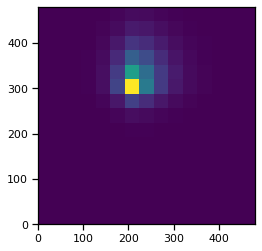

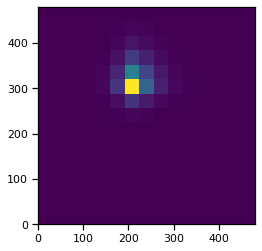

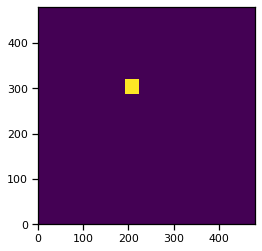

In [20]:
for i, dist in enumerate(dists):
    plot_2d_dist(plt.gca(), ss.states, dist)
    plt.xlim(0, step * 15); plt.ylim(0, step * 15)
    plt.gca().set_aspect('equal')
#     plt.imshow(dist[1:].reshape(15,15), origin='lower')
#     plt.colorbar()
    plt.show()

## Bridging dynamics

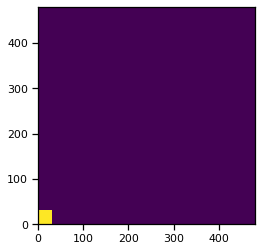

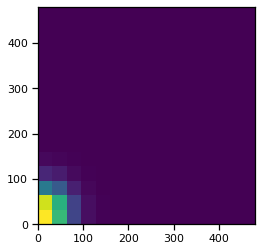

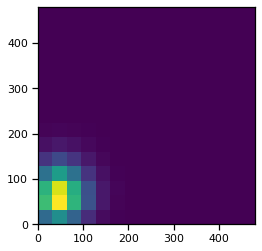

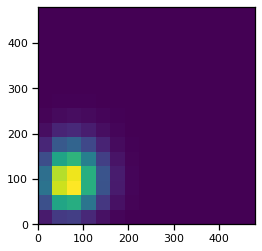

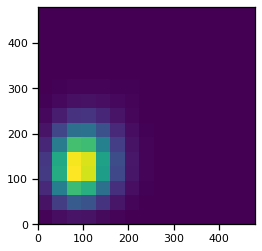

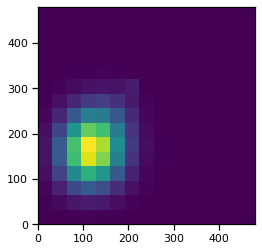

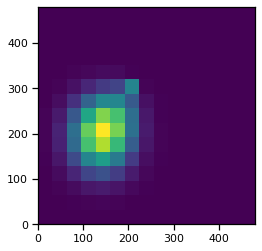

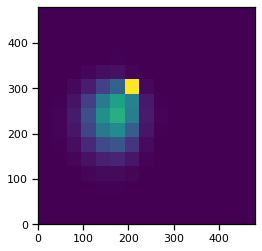

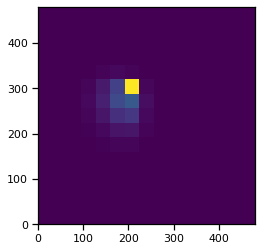

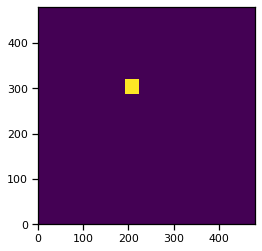

In [21]:
for i, dist in enumerate(dists[:granularity] * dists[granularity:]):
    dist = np.maximum(0, dist)
    plot_2d_dist(plt.gca(), ss.states, dist)
    plt.xlim(0, step * 15); plt.ylim(0, step * 15)
    plt.gca().set_aspect('equal')
    plt.show()

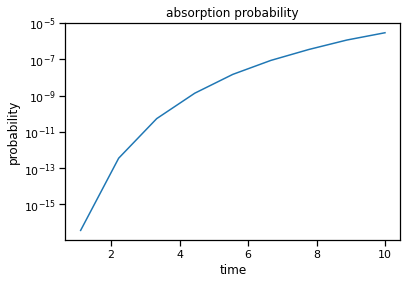

In [22]:
tspan = np.linspace(t0, t_max, granularity)
plt.plot(tspan[1:], (dists[:granularity] * dists[granularity:]).T[tgt_idx][1:])
plt.yscale('log'); plt.title('absorption probability')
plt.xlabel('time'); plt.ylabel('probability');

# Parallel Poisson Processes for Rare Event Probs

In [23]:
reaching_probs = dict()
iteration_sss  = dict()
spaces         = dict()

In [24]:
print('-> Setting up integration')
model = MassActionCRN(
    np.array([[0, 0], [0, 0]]),
    np.array([[1, 0], [0, 1]]),
    np.array([1, 1]))
size_exp = 4
step = 2 ** size_exp
states = [MacroState((x1, x2), (step, step))
          for x1, x2 in itertools.product(range(0, step * 10, step), range(0, step * 10, step))
          if x1 < 64 or x2 < 64]
states.append(MacroState((64, 64), (96, 96)))
ss = StateSpace(states, model, sink=True)

-> Setting up integration


-> Make 1 targets absorbing
-> Number of states: 66
-> Forwards integration
 - integrated to t=20
-> Backwards integration
-> Plotting state space
-> Truncate 30 states
-> Split 36 remaining states
-> Make 1 targets absorbing
-> Number of states: 138
-> Forwards integration
 - integrated to t=20
-> Backwards integration
-> Plotting state space
-> Truncate 48 states
-> Split 90 remaining states
-> Make 1 targets absorbing
-> Number of states: 354
-> Forwards integration
 - integrated to t=20
-> Backwards integration
-> Plotting state space
-> Truncate 138 states
-> Split 216 remaining states
-> Make 1 targets absorbing
-> Number of states: 858
-> Forwards integration
 - integrated to t=20
-> Backwards integration
-> Plotting state space
-> Truncate 324 states
-> Split 534 remaining states
-> Make 1 targets absorbing
-> Number of states: 2130
-> Forwards integration
 - integrated to t=20
-> Backwards integration
-> Plotting state space
-> Done


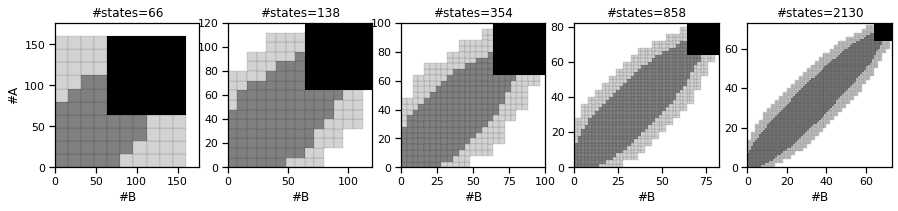

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

In [25]:
tgt_idx  = lambda: [tuple(s.origin) for s in ss.states].index((64, 64))
is_tgt = lambda state: state.origin[0] >= 64 and state.origin[1] >= 64
is_tgt = lambda state: state.origin[0] == 64 and state.origin[1] == 64
init_idx = lambda: [tuple(s.origin) for s in ss.states].index((0, 0))

t_max = 20
granularity = 50
dt = t_max / granularity
tspan = np.linspace(0, t_max, granularity)
refinement_steps = size_exp
threshold = 1e-3

y = np.zeros(len(ss))
y[init_idx()] = 1
integrator = LumpingCMEIntegrator(model, ss, y, threshold, 0, t_max, max_step=dt / 10)
integrator.add_sink_state()
granularity = 50


fig, axes = plt.subplots(ncols=refinement_steps + 1, figsize=(3 * (refinement_steps + 1), 3.5))
refinements_done = 0
max_cnt = step * 10
axes[0].set_ylabel('#A')
sss = []
while True:
    sss.append(len(ss))
        
    terminal = [idx for idx, state in enumerate(ss.states) if is_tgt(state)]
    print('-> Make {} targets absorbing'.format(len(terminal)))
    for idx in terminal:
        integrator.make_absorbing(idx)
        assert np.all(ss.q_matrix.data[idx] == 0)
        

    print('-> Number of states:', len(ss))
    forward  = np.zeros((granularity, len(ss)))
    backward = np.zeros((granularity, len(ss)))
    dists    = np.vstack([forward, backward])


    # forward integration
    print('-> Forwards integration')
    y_init = np.zeros(len(ss))
    y_init[init_idx()] = 1
    integrator.y = y_init
    dists[0] = y_init
    steps = 1
    t_log = 0
    while integrator.t < t_max:
        integrator.step()

        # Logging
        if integrator.t >= tspan[steps]:
            assert steps <= granularity
            dists[steps] = integrator.y
            steps += 1
    print(' - integrated to t={}'.format(integrator.t))

    # backward integration
    print('-> Backwards integration')
    integrator.switch_direction()
    y_term = np.zeros(len(ss))
    y_term[terminal] = 1
    integrator.y = y_term
    dists[-1] = y_term
    t_log = 0
    steps = granularity - 1
    while integrator.t < t_max:
        integrator.step()

        # Logging
        if integrator.t >= tspan[granularity - steps]:
            dists[granularity + steps - 1] = integrator.y
            steps -= 1
    integrator.switch_direction()
    
    for idx in terminal:
        integrator.undo_absorbing(idx)

    blacklist = [0, init_idx()] + terminal
    bridges = dists[:granularity] * dists[granularity:]
    bridges /= bridges.sum(1).reshape(granularity, -1)
    bridges = bridges.max(0)

    to_be_truncated = [i for i in range(len(ss)) if bridges[i] < threshold and i not in blacklist]
    
    print('-> Plotting state space')
    fig = plt.figure(figsize=(5, 5))
    ax = axes[refinements_done]
    ax.set_aspect('equal')
    dist = - ss.q_matrix.data.diagonal()
    dist /= dist.max()
    dist *= 255
    for i, box in enumerate(ss.states):
        color = ('grey' if i not in to_be_truncated else 'lightgrey') if not is_tgt(box) else 'k'
        ##plt.get_cmap('viridis').colors[int(dist[i])] if i in (np.where(ss.q_matrix.data[:,0] == 0))[0] else 'red'
        ##plt.get_cmap('viridis').colors[int(dist[i])]
        patch = Rectangle(box.origin, box.extent[0], box.extent[1], zorder=0,
                          facecolor=color, lw=.1, edgecolor='k', fill=True)
        ax.add_patch(patch)
    max_cnt = max(s.origin[0] + s.extent[0] for s in ss.states)
#     if refinements_done > 0:
#         patch = Rectangle((0, 0), max_cnt, max_cnt, fill=False, edgecolor='k',
#                           zorder=9, lw=2, linestyle='--')
#         prevax = axes[refinements_done - 1]
#         prevax.add_patch(patch)
    lims = max(s.origin[0] + s.extent[0]*2 for s in ss.states if not is_tgt(s))
    ax.set_xlim(0, lims)
    ax.set_ylim(0, lims)
    ax.set_xlabel('#B'); ax.set_title('#states={}'.format(len(ss)))
        
    if refinements_done >= refinement_steps:
        break
    print('-> Truncate {} states'.format(len(to_be_truncated)))
    integrator.remove(to_be_truncated, redirect2sink=True)
    rem_states = len(ss)
    print('-> Split {} remaining states'.format(rem_states))
    for i in range(rem_states):
        print(' - {:.2f}%'.format(100 * (i + 1) / rem_states), end='\r', flush=True)
        if is_tgt(ss.states[i]):
            continue
        ss.split(i, [0, 1])
    

    refinements_done += 1
print('-> Done')
reaching_probs[threshold] = dists[:granularity, tgt_idx()]
iteration_sss[threshold] = sss
spaces[threshold] = ss
# plt.tight_layout()
plt.savefig('refinement.pdf')

1.8486047517948978e-29
relative error = 0.007496025557838197


(1.8486047517948978e-29, 1.8625665986213392e-29)

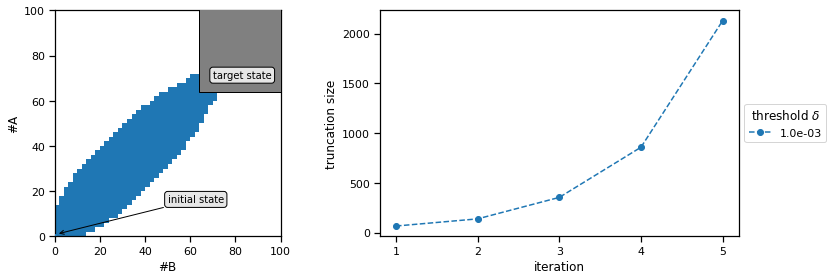

In [26]:
fig, (ax1, ax2) = plt.subplots(figsize=(12, 4), ncols=2)
true_probs = [sum(poisson(t).pmf(x) for x in range(64, 200)) ** 2
              for t in tspan]
true_prob = true_probs[-1]

for i, (threshold, color) in enumerate(zip(sorted(reaching_probs.keys()), sns.color_palette())):
#     for i, box in enumerate(spaces[threshold].states):
#         patch = Rectangle(box.origin, box.extent[0], box.extent[1], zorder=i,
#                           lw=.1, edgecolor='k', fill=False
#                          )
#         ax1.add_patch(patch)
    for i, box in enumerate(spaces[threshold].states):
        patch = Rectangle(box.origin, box.extent[0], box.extent[1], zorder=7-i,
                          facecolor=color, lw=0, edgecolor='k', fill=True
                         )
        ax1.add_patch(patch)
#         break
    print(reaching_probs[threshold][-1])
    sss = iteration_sss[threshold]
    ax2.plot(range(1, len(sss) + 1), sss, '--', marker='o',
             color=color, label='{:1.1e}'.format(threshold))
patch = Rectangle((64, 64), 100, 100, zorder=8, facecolor='grey', fill=True,
                 lw = 1, edgecolor='k')
ax1.add_patch(patch)

bbox = dict(boxstyle="round", fc="0.9")
arrowprops = dict(
    arrowstyle = "->",
    color='k',)
tgt_state = ss.states[tgt_idx()]
init_state = ss.states[init_idx()]
ax1.annotate('target state', xy=tuple(x + 1 for x in tgt_state.origin),
            xytext=(70, 70), color='black', size=10, zorder=9,
             bbox=bbox)

ax1.annotate('initial state', xy=tuple(x + 1 for x in init_state.origin),
            xytext=(50, 15), color='black', size=10,zorder=9,
            arrowprops=arrowprops, bbox=bbox)
ax1.set_ylim(0, 100)
ax1.set_xlim(0, 100)
ax1.set_xlabel('#B')
ax1.set_ylabel('#A')
ax1.set_aspect('equal')
ax2.set_xticks(list(range(1, len(sss) + 1)))
ax2.set_xticklabels(list(range(1, len(sss) + 1)))
ax2.set_ylabel('truncation size')
ax2.set_xlabel('iteration')
# ax2.set_yscale('log')
ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5), title=r'threshold $\delta$')
plt.tight_layout()
plt.savefig('truncs.png')
est_prob = dists[granularity - 1, tgt_idx()]
rel_err = (true_prob - est_prob) / true_prob
print('relative error =', rel_err)
est_prob, true_prob

In [27]:
fact = lambda n: np.prod([np.float128(i) for i in range(1, n + 1)])
poisson_pmf = lambda lam, k: np.float128(lam) ** np.float128(k) * np.exp(-np.float128(lam)) / fact(k)
side_prb = np.sum([poisson_pmf(20, k) for k in range(64)])
tail = np.sum([poisson_pmf(20, i) for i in range(64, 400)])
1 - (side_prb ** 2 + 2 * tail * (1 - side_prb))

8.6315503355915979e-15

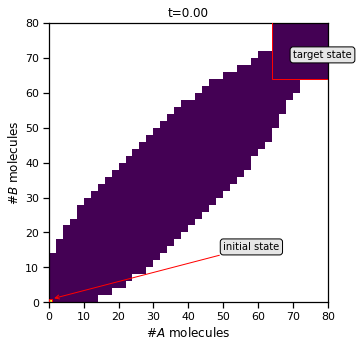

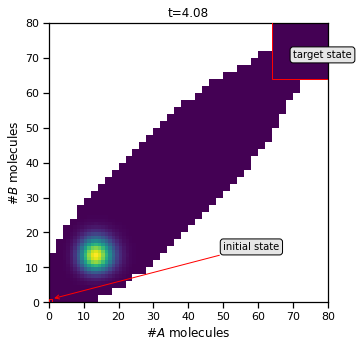

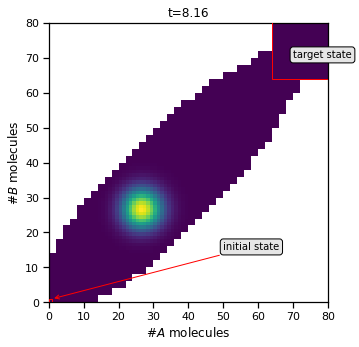

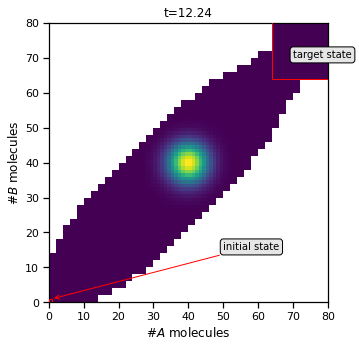

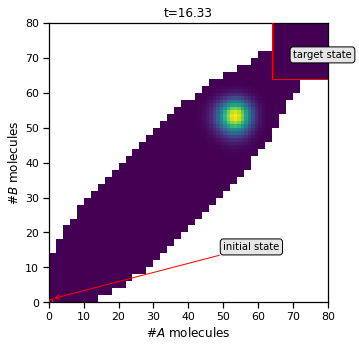

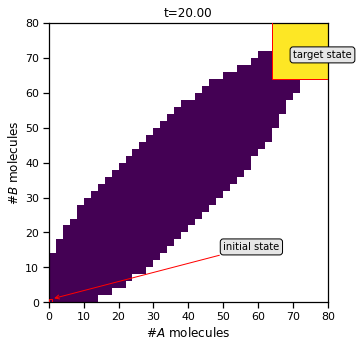

In [28]:
tspan = np.linspace(0, t_max, granularity)
bridges = dists[:granularity] * dists[granularity:]
bridges /= bridges.sum(1).reshape(granularity, -1)
for k in list(range(0, len(bridges), 10)) + [len(bridges) - 1]:
    bridge = bridges[k]
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111, aspect='equal')
    plot_2d_dist(ax, ss.states, bridge)
    
    tgt_state = ss.states[tgt_idx()]
    patch = Rectangle(tgt_state.origin, tgt_state.extent[0], tgt_state.extent[1],
                  lw=1, edgecolor='r', fill=False, zorder=9
                 )
    ax.add_patch(patch)
    init_state = ss.states[init_idx()]
    patch = Rectangle(init_state.origin, init_state.extent[0], init_state.extent[1],
                  lw=1, edgecolor='r', fill=False, zorder=9
                 )
    ax.add_patch(patch)
    offset = 25
    
    bbox = dict(boxstyle="round", fc="0.9")
    arrowprops = dict(
        arrowstyle = "->",
        color='red',)
    ax.annotate('target state', xy=tuple(x + 1 for x in tgt_state.origin),
                xytext=(70, 70), color='black', size=10,
                 bbox=bbox)
    ax.annotate('initial state', xy=tuple(x + 1 for x in init_state.origin),
                xytext=(50, 15), color='black', size=10,
                arrowprops=arrowprops, bbox=bbox)
    
    ax.set_xlim(0, 80)
    ax.set_ylim(0, 80)
    
    ax.set_xlabel(r'#$A$ molecules')
    ax.set_ylabel(r'#$B$ molecules')
    
    ax.set_title('t={:.2f}'.format(tspan[k]))
    plt.tight_layout()
    plt.savefig('2poisson_bridge_{}.pdf'.format(k))
    
    plt.show()

# Hybrid model

## Exclusive switch

$$ D \rightarrow D + P_1 \quad D \rightarrow D + P_2 \quad P_1 \rightarrow \varnothing \quad P_2 \rightarrow \varnothing $$
$$ D + P_1 \rightarrow D.P1 \quad D.P1 \rightarrow D + P1 \quad D.P1 \rightarrow D.P1 + P1 $$
$$ D + P_2 \rightarrow D.P2 \quad D.P2 \rightarrow D + P2 \quad D.P2 \rightarrow D.P2 + P2 $$

This system has 3 distinct modes: $D$, $D.P1$, and $D.P2$. We model this state space by stacking 3 two-dimensional grids.

In [29]:
print('-> Setting up state space')

# species order: P1, P2, D, D.P1, D.P2
excl_switch = MassActionCRN(
    np.array([[0, 0, 1, 0, 0], # D -> D + P1
              [0, 0, 1, 0, 0], # D -> D + P2
              [1, 0, 0, 0, 0], # P1 -> 0
              [0, 1, 0, 0, 0], # P2 -> 0
              [1, 0, 1, 0, 0], # D + P1 -> D.P1
              [0, 0, 0, 1, 0], # D.P1 -> D + P1
              [0, 0, 0, 1, 0], # D.P1 -> D.P1 + P1
              [0, 1, 1, 0, 0], # D + P2 -> D.P2
              [0, 0, 0, 0, 1], # D.P2 -> D + P2
              [0, 0, 0, 0, 1], # D.P2 -> D.P2 + P2
             ]),
    np.array([[1, 0, 1, 0, 0], # D -> D + P1
              [0, 1, 1, 0, 0], # D -> D + P2
              [0, 0, 0, 0, 0], # P1 -> 0
              [0, 0, 0, 0, 0], # P2 -> 0
              [0, 0, 0, 1, 0], # D + P1 -> D.P1
              [1, 0, 1, 0, 0], # D.P1 -> D + P1
              [1, 0, 0, 1, 0], # D.P1 -> D.P1 + P1
              [0, 0, 0, 0, 1], # D + P2 -> D.P2
              [0, 1, 1, 0, 0], # D.P2 -> D + P2
              [0, 1, 0, 0, 1], # D.P2 -> D.P2 + P2,
             ]),
    np.array([.1,   # D -> D + P1
              .1,   # D -> D + P2
              .001, # P1 -> 0
              .001, # P2 -> 0
              .01,  # D + P1 -> D.P1
              .008, # D.P1 -> D + P1
              .1,   # D.P1 -> D.P1 + P1
              .01,  # D + P2 -> D.P2
              .008, # D.P2 -> D + P2
              .1,   # D.P2 -> D.P2 + P2,
             ])
)

-> Setting up state space


In [30]:
state_size = 2 ** 4
num_steps = 5
mk_grid = lambda state_size, num_steps, mode: [
    MacroState(
        tuple([x1, x2] + mode),
        tuple([state_size, state_size] + [1] * len(mode)))
    for x1, x2 in itertools.product(
        range(0, state_size * num_steps, state_size),
        range(0, state_size * num_steps, state_size))]
states_D   = mk_grid(state_size, num_steps, [1, 0, 0])
states_DP1 = mk_grid(state_size, num_steps, [0, 1, 0])
states_DP2 = mk_grid(state_size, num_steps, [0, 0, 1])
states = states_D + states_DP1 + states_DP2
print('-> Set up model')
ss = StateSpace(states, excl_switch, sink=True)

-> Set up model


In [31]:
print('-> Split 1')
for i in range(len(ss)):
    ss.split(i, [0, 1])
print('-> Split 2')
for i in range(len(ss)):
    ss.split(i, [0, 1])

-> Split 1
-> Split 2


In [32]:
t_max = 100
y = np.zeros(len(ss))
y[1] = 1
t = 0

integrator = LumpingCMEIntegrator(excl_switch, ss, y, 1e-3)

In [33]:
while integrator.t < t_max:
    print(len(integrator), integrator.t, integrator.y[0], end='\r')
    integrator.step()

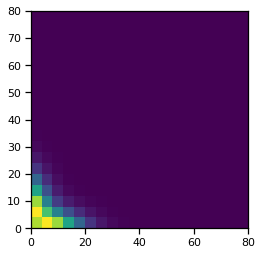

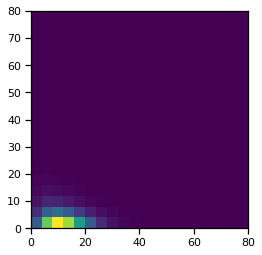

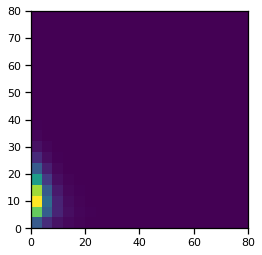

In [34]:
for mode in [(1, 0, 0), (0, 1, 0), (0, 0, 1)]:
    sp = [(s, p) for s, p in zip(ss.states, integrator.y) if np.all(s.origin[2:] == mode)]
    states = np.array([s for s, _ in sp])
    probs  = np.array([p for _, p in sp])
    fig = plt.figure() # figsize=(10, 10))
    ax = fig.add_subplot(111, aspect='equal')
    plot_2d_dist(ax, states, probs, xlim=(0, 5*2**4), ylim=(0, 5*2**4))
plt.show()

## Mode switching

In [35]:
print('-> Setting up state space')
state_size = 2 ** 4
num_steps = 5
mk_grid = lambda state_size, num_steps, mode: [
    MacroState(
        tuple([x1, x2] + mode),
        tuple([state_size, state_size] + [1] * len(mode)))
    for x1, x2 in itertools.product(
        range(0, state_size * num_steps, state_size),
        range(0, state_size * num_steps, state_size))]
states_D   = mk_grid(state_size, num_steps, [1, 0, 0])
states_DP1 = mk_grid(state_size, num_steps, [0, 1, 0])
states_DP2 = mk_grid(state_size, num_steps, [0, 0, 1])
states = states_D + states_DP1 + states_DP2
print('-> Set up model')
ss = StateSpace(states, excl_switch, sink=True)

-> Setting up state space
-> Set up model


In [36]:
print('-> Split 1')
for i in range(len(ss)):
    ss.split(i, [0, 1])
# print('-> Split 2')
# for i in range(len(ss)):
#     ss.split(i, [0, 1])

-> Split 1


In [37]:
t_max = 10
granularity = 40
dt = t_max / granularity

tgt_idx  = lambda: [tuple(s.origin) for s in ss.states].index((32, 0, 0, 1, 0))
init_idx = lambda: [tuple(s.origin) for s in ss.states].index((0, 32, 0, 0, 1))

y = np.zeros(len(ss))
y[init_idx()] = 1
integrator = LumpingCMEIntegrator(excl_switch, ss, y, .1e-3, 0, t_max)
integrator.add_sink_state()

# integrator.make_absorbing(tgt_idx())

print('-> Number of states:', len(ss))
forward  = np.zeros((granularity, len(ss)))
backward = np.zeros((granularity, len(ss)))
dists    = np.vstack([forward, backward])

# forward integration
print('-> Forwards integration')
y_init = np.zeros(len(ss))
y_init[init_idx()] = 1
integrator.y = y_init
steps = 0
t_log = 0
while integrator.t < t_max:
    integrator.step()

    # Logging
    while integrator.t > t_log:
        print('.', end='')
        dists[steps] = integrator.y
        t_log = t_log + dt
        steps += 1

# backward integration
print('\n-> Backwards integration')
integrator.switch_direction()
y_term = np.zeros(len(ss))
y_term[tgt_idx()] = 1
integrator.y = y_term
t_log = 0
while integrator.t < t_max:
    integrator.step()

    # Logging
    while integrator.t > t_log:
        print('.', end='')
        dists[granularity + steps - 1] = integrator.y
        t_log = t_log + dt
        steps -= 1
integrator.switch_direction()

-> Number of states: 301
-> Forwards integration
........................................
-> Backwards integration
........................................

In [38]:
bridge = dists[:granularity] * dists[granularity:]
bridge /= bridge.sum(1).reshape(granularity, -1)

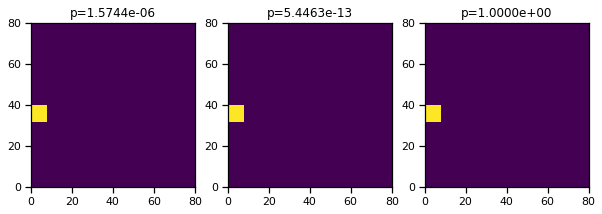

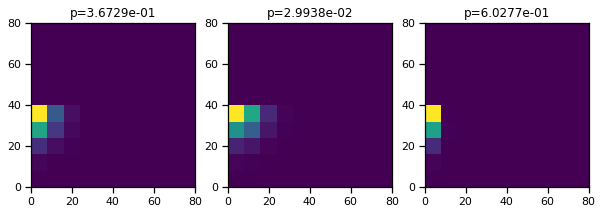

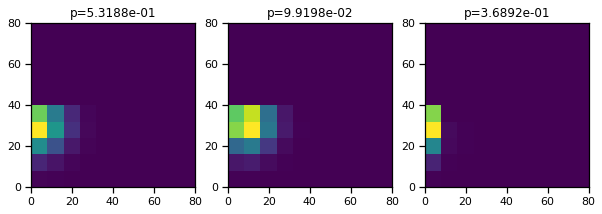

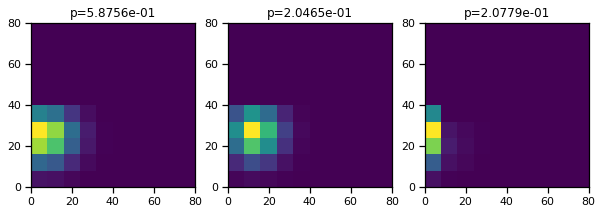

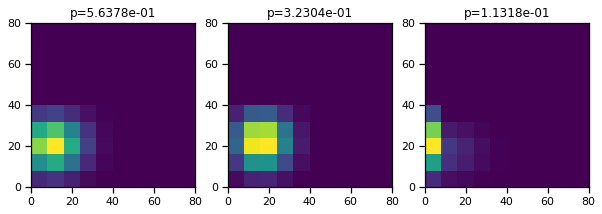

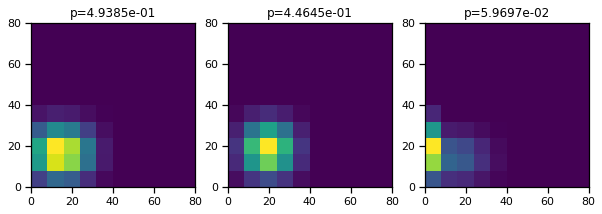

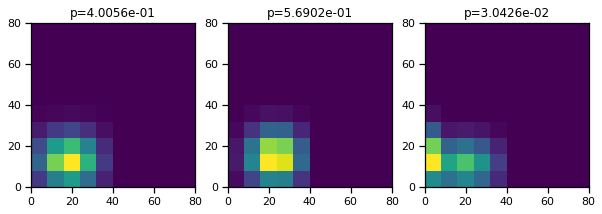

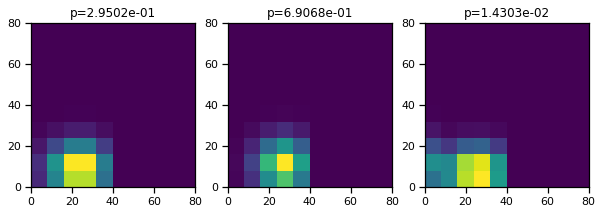

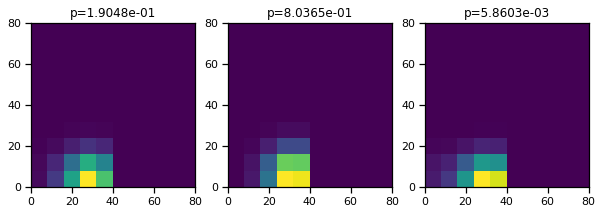

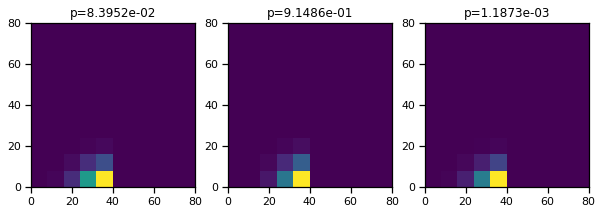

In [39]:
for k in range(0, granularity, 4):
    fig, axes = plt.subplots(ncols=3, figsize=(10, 5))
    for mode, ax in zip([(1, 0, 0), (0, 1, 0), (0, 0, 1)], axes):
        mode_prob = sum(p for s, p in zip(ss.states, bridge[k]) if np.all(s.origin[2:] == mode))
        ax.set_title('p={:.4e}'.format(mode_prob))
        ax.set_aspect('equal')
        sp = [(s, p) for s, p in zip(ss.states, bridge[k]) if np.all(s.origin[2:] == mode)]
        states = np.array([s for s, _ in sp])
        probs  = np.array([p for _, p in sp])
        plot_2d_dist(ax, states, probs, xlim=(0, 5*2**4), ylim=(0, 5*2**4))
    plt.show()

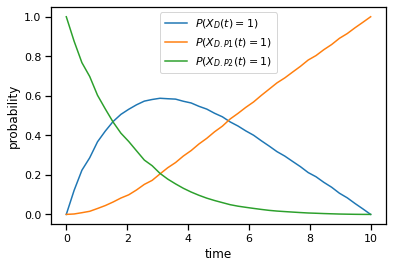

In [40]:
mode_probs_coarse = list()
for k in range(granularity):
    mode_probs_coarse.append(np.array([
        sum(p for s, p in zip(ss.states, bridge[k]) if np.all(s.origin[2:] == mode))
        for mode in [(1, 0, 0), (0, 1, 0), (0, 0, 1)]
    ]))
mode_probs_coarse = np.array(mode_probs_coarse).T
tspan_coarse = np.linspace(0, t_max, granularity)
plt.plot(tspan_coarse, mode_probs_coarse[0], label=r'$P(X_{D}(t) = 1)$')
plt.plot(tspan_coarse, mode_probs_coarse[1], label=r'$P(X_{D.P1}(t) = 1)$')
plt.plot(tspan_coarse, mode_probs_coarse[2], label=r'$P(X_{D.P2}(t) = 1)$')
plt.xlabel('time'); plt.ylabel('probability')
plt.legend(); plt.savefig('mode_switching_excl_switch_coarse.pdf')

# Mode switching with refinement

In [41]:
print('-> Setting up state space')
state_size = 2 ** 4
num_steps = 5
mk_grid = lambda state_size, num_steps, mode: [
    MacroState(
        tuple([x1, x2] + mode),
        tuple([state_size, state_size] + [1] * len(mode)))
    for x1, x2 in itertools.product(
        range(0, state_size * num_steps, state_size),
        range(0, state_size * num_steps, state_size))]
states_D   = mk_grid(state_size, num_steps, [1, 0, 0])
states_DP1 = mk_grid(state_size, num_steps, [0, 1, 0])
states_DP2 = mk_grid(state_size, num_steps, [0, 0, 1])
states = states_D + states_DP1 + states_DP2
print('-> Set up model')
ss = StateSpace(states, excl_switch, sink=True)

-> Setting up state space
-> Set up model


In [42]:
print('-> Split 1')
for i in range(len(ss)):
    ss.split(i, [0, 1])

-> Split 1


In [43]:
t_max = 10
granularity = 50
dt = t_max / granularity
refinement_steps = 3
threshold = 1e-4

tgt_idx  = lambda: [tuple(s.origin) for s in ss.states].index((32, 0, 0, 1, 0))
init_idx = lambda: [tuple(s.origin) for s in ss.states].index((0, 32, 0, 0, 1))

y = np.zeros(len(ss))
y[init_idx()] = 1
integrator = LumpingCMEIntegrator(excl_switch, ss, y, threshold, 0, t_max)
integrator.add_sink_state()

refinements_done = 0
while True:
    print('-> Number of states:', len(ss))
    forward  = np.zeros((granularity, len(ss)))
    backward = np.zeros((granularity, len(ss)))
    dists    = np.vstack([forward, backward])

    # forward integration
    print('-> Forwards integration')
    y_init = np.zeros(len(ss))
    y_init[init_idx()] = 1
    integrator.y = y_init
    steps = 0
    t_log = 0
    while integrator.t < t_max:
        integrator.step()

        # Logging
        while integrator.t > t_log:
            dists[steps] = integrator.y
            t_log = t_log + dt
            steps += 1

    # backward integration
    print('-> Backwards integration')
    integrator.switch_direction()
    y_term = np.zeros(len(ss))
    y_term[tgt_idx()] = 1
    integrator.y = y_term
    t_log = 0
    steps = granularity
    while integrator.t < t_max:
        integrator.step()

        # Logging
        while integrator.t > t_log:
            dists[granularity + steps - 1] = integrator.y
            t_log = t_log + dt
            steps -= 1
    integrator.switch_direction()
    
    if refinements_done >= refinement_steps:
        break

    blacklist = [0]
    bridges = dists[:granularity] * dists[granularity:]
    bridges /= bridges.sum(1).reshape(granularity, -1)
    if refinements_done >= refinement_steps:
        break
    print('-> Refinement')
    bridge_probs = bridges.max(0)
    blacklist = [0, init_idx(), tgt_idx()]
    to_be_truncated = [i for i in range(len(ss)) if bridge_probs[i] < threshold
                       and i not in blacklist]
    print('-> Truncate {} states'.format(len(to_be_truncated)))
    integrator.remove(to_be_truncated, redirect2sink=True)
    rem_states = len(ss)
    print('-> Split {} remaining states'.format(rem_states))
    for i in range(rem_states):
        print(' - {:.2f}%'.format(100 * (i + 1) / rem_states), end='\r', flush=True)
        ss.split(i, [0, 1])

    refinements_done += 1
print('-> Done')

-> Number of states: 301
-> Forwards integration
-> Backwards integration
-> Refinement
-> Truncate 227 states
-> Split 74 remaining states
-> Number of states: 293
-> Forwards integration
-> Backwards integration
-> Refinement
-> Truncate 76 states
-> Split 217 remaining states
-> Number of states: 865
-> Forwards integration
-> Backwards integration
-> Refinement
-> Truncate 302 states
-> Split 563 remaining states
-> Number of states: 2249
-> Forwards integration
-> Backwards integration
-> Done


...
...
...
...
...


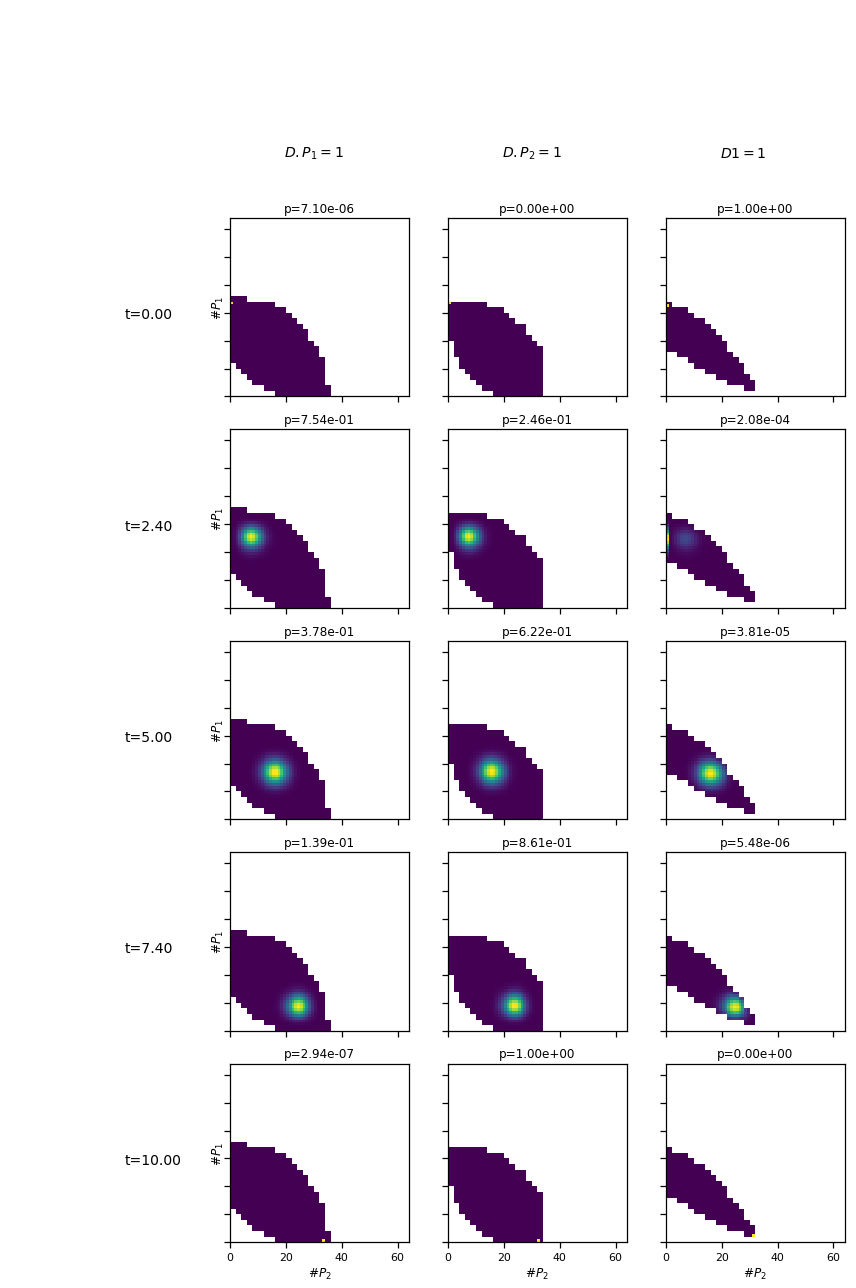

In [44]:
bridge = dists[:granularity] * dists[granularity:]
bridge /= bridge.sum(1).reshape(granularity, -1)
idcs = np.linspace(0, granularity - 1, 5).astype(int)
fig, axes = plt.subplots(ncols=4, nrows=len(idcs) + 1, figsize=(12, 3 * len(idcs) + 3), sharex=True, sharey=True)
for k, axes_r in zip(idcs, axes[1:,1:]):
    minp, maxp = bridge[k].min(), bridge[k].max()
    for mode, ax in zip([(1, 0, 0), (0, 1, 0), (0, 0, 1)], axes_r):
        print('.', end='')
        mode_prob = sum(p for s, p in zip(ss.states, bridge[k]) if np.all(s.origin[2:] == mode))
        ax.set_title('p={:.2e}'.format(mode_prob if mode_prob > 1e-9 else 0))
        ax.set_aspect('equal')
        sp = [(s, p) for s, p in zip(ss.states, bridge[k]) if np.all(s.origin[2:] == mode)]
        states = np.array([s for s, _ in sp])
        probs  = np.array([p for _, p in sp])
        plot_2d_dist(ax, states, probs, xlim=(0, 4*2**4), ylim=(0, 4*2**4))
    print()
for ax in axes[1:, 1]:
    ax.set_ylabel(r'#$P_1$')
for ax in axes[-1,1:]:
    ax.set_xlabel(r'#$P_2$')
idcs = np.linspace(0, granularity, 5).astype(int)
for i, ax in zip(idcs, axes[1:,0]):
    ax.axis('off')
    ax.text(40, 28, 't={:.2f}'.format(i * dt), fontsize=14)
for i in range(4):
    axes[0, i].axis('off')
axes[0,1].text(20, 10, r'$D.P_1=1$', fontsize=14)
axes[0,2].text(20, 10, r'$D.P_2=1$', fontsize=14)
axes[0,3].text(20, 10, r'$D1=1$', fontsize=14)
plt.tight_layout()
plt.savefig('excl_switch.pdf'.format(k))
plt.show()

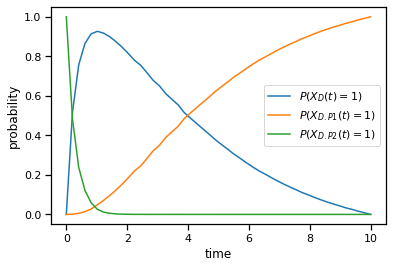

In [45]:
mode_probs = list()
for k in range(granularity):
    mode_probs.append(np.array([
        sum(p for s, p in zip(ss.states, bridge[k]) if np.all(s.origin[2:] == mode))
        for mode in [(1, 0, 0), (0, 1, 0), (0, 0, 1)]
    ]))
mode_probs = np.array(mode_probs).T
tspan = np.linspace(0, t_max, granularity)
plt.plot(tspan, mode_probs[0], label=r'$P(X_{D}(t) = 1)$')
plt.plot(tspan, mode_probs[1], label=r'$P(X_{D.P1}(t) = 1)$')
plt.plot(tspan, mode_probs[2], label=r'$P(X_{D.P2}(t) = 1)$')
plt.xlabel('time'); plt.ylabel('probability')
plt.legend(); plt.savefig('excl_switch_modeprobs.pdf')

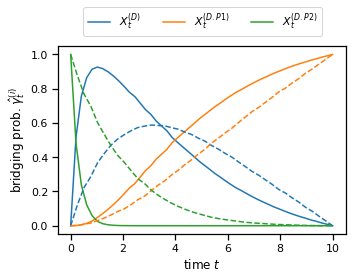

In [46]:
plt.figure(figsize=(5,4))
tspan = np.linspace(0, t_max, 50)
p1 = plt.plot(tspan, mode_probs[0], label=r'$X^{(D)}_t$')
p2 = plt.plot(tspan, mode_probs[1], label=r'$X^{(D.P1)}_t$')
p3 = plt.plot(tspan, mode_probs[2], label=r'$X^{(D.P2)}_t$')

plt.plot(tspan_coarse, mode_probs_coarse[0], '--', color=p1[0].get_color())#, label=r'coarse $P(X_{D}(t) = 1)$')
plt.plot(tspan_coarse, mode_probs_coarse[1], '--', color=p2[0].get_color())#, label=r'coarse $P(X_{D.P1}(t) = 1)$')
plt.plot(tspan_coarse, mode_probs_coarse[2], '--', color=p3[0].get_color())#, label=r'coarse $P(X_{D.P2}(t) = 1)$')
plt.xlabel(r'time $t$'); plt.ylabel(r'bridging prob. $\hat\gamma^{(i)}_t$')
plt.legend(bbox_to_anchor=(0.09, 1.05, 1., .105), loc='lower left',# mode='expand',
           ncol=3, borderaxespad=0.)
plt.tight_layout()
plt.savefig('excl_switch_modeprobs.pdf')

# Hill-function Toggle Switch

### Model Specification

    parameters
      pa = 3.0
      pb = 3.0
      ka = 5.0
      kb = 5.0
      da = 0.1
      db = 0.1

    var A B

    reactions
      0 -> A @ pa/(B*ka + 1);
      0 -> B @ pb/(A*kb + 1);
      A -> 0 @ A*da;
      B -> 0 @ B*db;

    init
      A = 0
      B = 0


In [48]:
def hill_integral(p, k, macro_state, i):
    if macro_state.volume == 0:
        return 0
    ei = macro_state.extent[i]
    lo = macro_state.origin[i]
    if ei == 1:
        rate_sum = p / (k * lo + 1)
    else:
        hi = lo + ei
        rate_sum = p * (np.log(k * hi + 1) -  np.log(k * lo + 1))  / k
    return rate_sum * macro_state.volume / ei

In [49]:
def deg_prop_integral(d, macro_state, i):
    return sum(x[i] * d for x in macro_state.iter_micro_states())

In [50]:
pa = 10.0
pb = 10.0
ka = 1.0
kb = 1.0
da = 0.1
db = 0.1
hill_toggle = CRN(
    np.array([[0, 0], [0, 0], [1, 0], [0, 1]]),
    np.array([[1, 0], [0, 1], [0, 0], [0, 0]]),
    [
        (lambda x: pa / (x[1] * ka + 1)),
        (lambda x: pb / (x[0] * kb + 1)),
        (lambda x: x[0] * da),
        (lambda x: x[1] * db),
    ],
    prop_integrals=[
        (lambda x: hill_integral(pa, ka, x, 1)),
        (lambda x: hill_integral(pb, kb, x, 0)),
        (lambda x: sum(s[0] * da for s in x.iter_micro_states())),
        (lambda x: sum(s[1] * db for s in x.iter_micro_states())),
    ]
)

In [54]:
state_size = 2 ** 5
num_steps = 10
mk_grid = lambda state_size, num_steps: [
    MacroState(
        tuple([x1, x2]),
        tuple([state_size, state_size]))
    for x1, x2 in itertools.product(
        range(0, state_size * num_steps, state_size),
        range(0, state_size * num_steps, state_size))]
states   = mk_grid(state_size, num_steps)
print('-> Set up model')
ss = StateSpace(states, hill_toggle, sink=True)
# print('-> Split 1')
# for i in range(len(ss)):
#     ss.split(i, [0, 1])
# print('-> Split 2')
# for i in range(len(ss)):
#     ss.split(i, [0, 1])

-> Set up model


In [55]:
t_max = 5
y = np.zeros(len(ss))
y[1] = 1
t = 0

integrator = LumpingCMEIntegrator(hill_toggle, ss, y, 1e-3)

In [56]:
while integrator.t < t_max:
    print(len(integrator), integrator.t, integrator.y[0], end='\r')
    integrator.step()

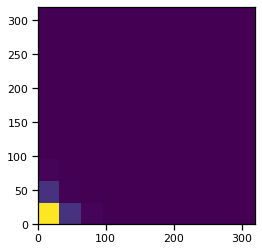

In [57]:
sp = [(s, p) for s, p in zip(ss.states, integrator.y)]
fig = plt.figure() # figsize=(10, 10))
ax = fig.add_subplot(111, aspect='equal')
plot_2d_dist(ax, ss.states, integrator.y, xlim=(0, num_steps * state_size),
             ylim=(0, num_steps * state_size))

## Bridging

In [58]:
size_exp = 10
state_size = 2 ** size_exp
num_steps = 10
mk_grid = lambda state_size, num_steps: [
    MacroState(
        [x1, x2],
        [state_size, state_size])
    for x1, x2 in itertools.product(
        range(0, state_size * num_steps, state_size),
        range(0, state_size * num_steps, state_size))]
states   = mk_grid(state_size, num_steps)
print('-> Set up model')
ss = StateSpace(states, hill_toggle, sink=True)

-> Set up model


In [59]:
t_max = 10
granularity = 101
dt = t_max / granularity
refinement_steps = size_exp
threshold = 1e-4

init_state = MacroState((0, 120), (1, 1))
tgt_state = MacroState((120, 0), (1, 1))

init_idx  = lambda: [init_state in s for s in ss.states].index(True)
tgt_idx = lambda: [tgt_state  in s for s in ss.states].index(True)

y = np.zeros(len(ss))
y[init_idx()] = 1
integrator = LumpingCMEIntegrator(model, ss, y, threshold, 0, t_max)
integrator.add_sink_state()

refinements_done = 0
while True:
    print('-> Bridging from {} to {} in t={}'.format(
        ss.states[init_idx()],
        ss.states[tgt_idx()],
        t_max,
    ))
    print('-> Number of states:', len(ss))
    forward  = np.zeros((granularity, len(ss)))
    backward = np.zeros((granularity, len(ss)))
    dists    = np.vstack([forward, backward])

    integrator.make_absorbing(tgt_idx())
    
    # forward integration
    print('-> Forwards integration')
    y_init = np.zeros(len(ss))
    y_init[init_idx()] = 1
    integrator.y = y_init
    steps = 0
    t_log = 0
    while integrator.t < t_max:
        integrator.step()

        # Logging
        while integrator.t > t_log:
            dists[steps] = integrator.y
            t_log = t_log + dt
            steps += 1

    # backward integration
    print('-> Backwards integration')
    integrator.switch_direction()
    y_term = np.zeros(len(ss))
    y_term[tgt_idx()] = 1
    integrator.y = y_term
    t_log = 0
    steps = granularity
    while integrator.t < t_max:
        integrator.step()

        # Logging
        while integrator.t > t_log:
            dists[granularity + steps - 1] = integrator.y
            t_log = t_log + dt
            steps -= 1
    integrator.switch_direction()
    
    if refinements_done >= refinement_steps:
        break
        
    
    integrator.undo_absorbing(tgt_idx())

    print('-> Refinement')
    blacklist = [0, init_idx(), tgt_idx()]
    min_volume = 2 ** (3 - 1 - refinements_done)
    bridges = dists[:granularity] * dists[granularity:]
    bridges /= bridges.sum(1).reshape(granularity, -1)
    bridges = bridges.max(0)
    to_be_truncated = [i for i in range(len(ss)) if bridges[i] < threshold and i not in blacklist]
    print('-> Truncate {} states'.format(len(to_be_truncated)))
    integrator.remove(to_be_truncated, redirect2sink=True)
    rem_states = len(ss)
    print('-> Split {} remaining states'.format(rem_states))
    for i in range(rem_states):
        print(' - {:.2f}%'.format(100 * (i + 1) / rem_states), end='\r', flush=True)
        ss.split(i, [0, 1])
    
    print()


    refinements_done += 1
print('-> Done')

-> Bridging from Box@[0 0]->[1024 1024] to Box@[0 0]->[1024 1024] in t=10
-> Number of states: 101
-> Forwards integration
-> Backwards integration
-> Refinement
-> Truncate 99 states
-> Split 2 remaining states
 - 100.00%
-> Bridging from Box@[0 0]->[512 512] to Box@[0 0]->[512 512] in t=10
-> Number of states: 5
-> Forwards integration
-> Backwards integration
-> Refinement
-> Truncate 3 states
-> Split 2 remaining states
 - 100.00%
-> Bridging from Box@[0 0]->[256 256] to Box@[0 0]->[256 256] in t=10
-> Number of states: 5
-> Forwards integration
-> Backwards integration
-> Refinement
-> Truncate 3 states
-> Split 2 remaining states
 - 100.00%
-> Bridging from Box@[0 0]->[128 128] to Box@[0 0]->[128 128] in t=10
-> Number of states: 5
-> Forwards integration
-> Backwards integration
-> Refinement
-> Truncate 3 states
-> Split 2 remaining states
 - 100.00%
-> Bridging from Box@[ 0 64]->[64 64] to Box@[64  0]->[64 64] in t=10
-> Number of states: 5
-> Forwards integration
-> Backwards

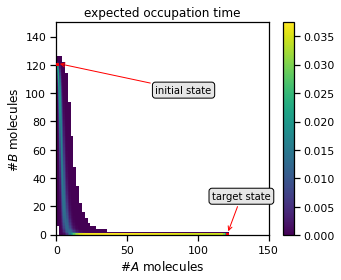

In [60]:
bridges = dists[:granularity] * dists[granularity:]
bridge = (bridges.T / bridges.sum(1)).T.sum(0) * t_max / granularity
bridge = np.minimum(np.unique(bridge)[-3], bridge)
sp = [(s, p) for s, p in zip(ss.states, bridge)]
size = 10
fig = plt.figure(figsize=(.5 * size, .4 * size))
ax = fig.gca()
plot_2d_dist(ax, ss.states, bridge)

patch = Rectangle(tgt_state.origin, tgt_state.extent[0], tgt_state.extent[1],
              lw=1, edgecolor='r', fill=True, facecolor='r', zorder=9
             )
ax.add_patch(patch)
patch = Rectangle(init_state.origin, init_state.extent[0], init_state.extent[1],
              lw=1, edgecolor='r', facecolor='r', fill=True, zorder=9
             )
ax.add_patch(patch)
offset = 25

bbox = dict(boxstyle="round", fc="0.9")
arrowprops = dict(
    arrowstyle = "->",
    color='red',)
ax.annotate('target state', xy=tuple(x + 1 for x in tgt_state.origin),
            xytext=(110, 25), color='black', size=10,
            arrowprops=arrowprops, bbox=bbox)
ax.annotate('initial state', xy=tuple(x + 1 for x in init_state.origin),
            xytext=(70, 100), color='black', size=10,
            arrowprops=arrowprops, bbox=bbox)

ax.set_xlim(-.5, 150)
ax.set_ylim(-.5, 150)

ax.set_xlabel(r'#$A$ molecules')
ax.set_ylabel(r'#$B$ molecules')

ax.set_title('expected occupation time'.format(dt * k))

fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=bridge.max())), ax=ax)

ax.set_aspect('equal')

plt.tight_layout()
plt.savefig('toggle_exp_occ.pdf'.format(k))
plt.show()

0.0 0.9999991508592486


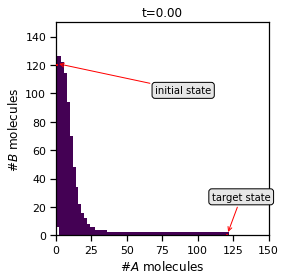

0.0 0.037235109259944346


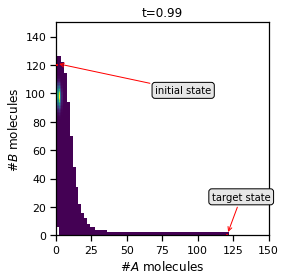

0.0 0.02476119298761017


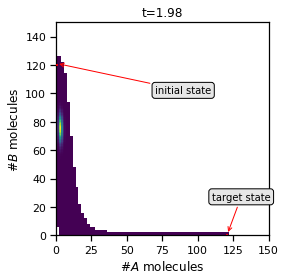

0.0 0.019835459036239816


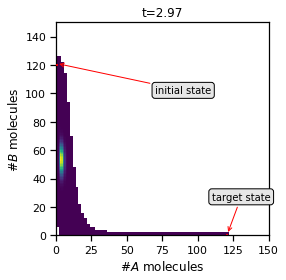

0.0 0.018139873786052224


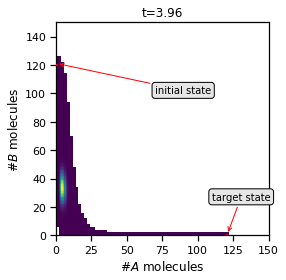

0.0 0.015547927062757342


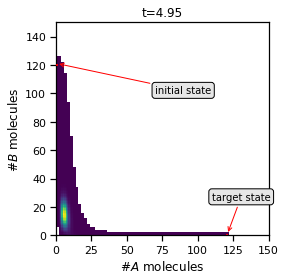

0.0 0.039297793371731435


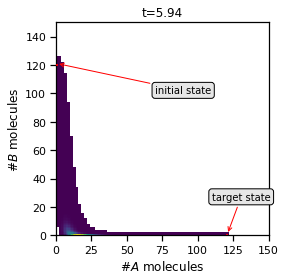

0.0 0.04895408126540016


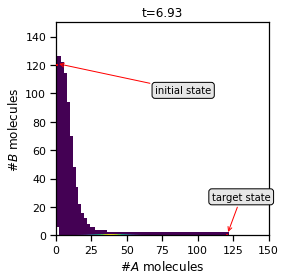

0.0 0.05515243981965246


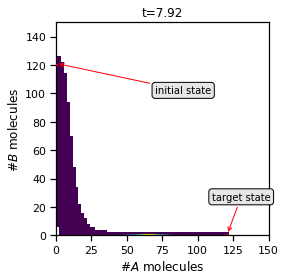

0.0 0.07087164802998339


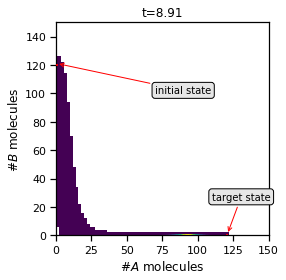

0.0 0.9999995147653638


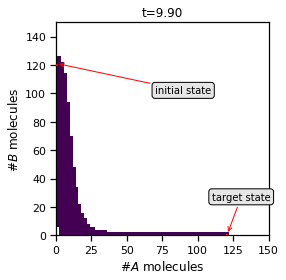

In [61]:
bridges = dists[:granularity] * dists[granularity:]
bridges /= bridges.sum(1).reshape(granularity, -1)
for k in range(0, len(bridges), 10):
    bridge = bridges[k]
    print(bridge.min(), bridge.max())
    sp = [(s, p) for s, p in zip(ss.states, bridge)]
    fig = plt.figure(figsize=(4, 4))
    ax = fig.add_subplot(111, aspect='equal')
    plot_2d_dist(ax, ss.states, bridge)
    
    patch = Rectangle(tgt_state.origin, tgt_state.extent[0], tgt_state.extent[1],
                  lw=1, edgecolor='r', fill=False, zorder=9
                 )
    ax.add_patch(patch)
    patch = Rectangle(init_state.origin, init_state.extent[0], init_state.extent[1],
                  lw=1, edgecolor='r', fill=False, zorder=9
                 )
    ax.add_patch(patch)
    offset = 25
    
    bbox = dict(boxstyle="round", fc="0.9")
    arrowprops = dict(
        arrowstyle = "->",
        color='red',)
    ax.annotate('target state', xy=tuple(x + 1 for x in tgt_state.origin),
                xytext=(110, 25), color='black', size=10,
                arrowprops=arrowprops, bbox=bbox)
    ax.annotate('initial state', xy=tuple(x + 1 for x in init_state.origin),
                xytext=(70, 100), color='black', size=10,
                arrowprops=arrowprops, bbox=bbox)
    
    ax.set_xlim(0, 150)
    ax.set_ylim(0, 150)
    
    ax.set_xlabel(r'#$A$ molecules')
    ax.set_ylabel(r'#$B$ molecules')
    
    ax.set_title('t={:.2f}'.format(dt * k))
    
    plt.tight_layout()
    plt.savefig('toggle_{}.png'.format(k))
    plt.show()

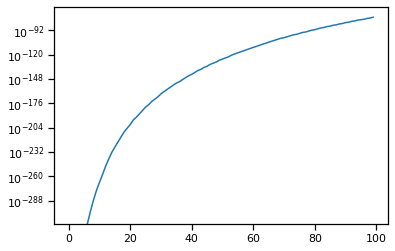

In [62]:
plt.plot(dists[:granularity - 1,tgt_idx()])
plt.yscale('log')

# SEIR

$$ S + I \rightarrow E + I, \qquad E \rightarrow I, \qquad I \rightarrow R $$

In [70]:
# species order S, E, I
seir = MassActionCRN(
    np.array([[1, 0, 1],
              [0, 1, 0],
              [0, 0, 1]]),
    np.array([[0, 1, 1],
              [0, 0, 1],
              [0, 0, 0]]),
    np.array([.5, 3, 3])
)

In [73]:
i1, i2 = 1, 0
im2 = np.zeros((128, 128))
for s in ss.states:
    im2[s.origin[i1], s.origin[i2]] = 1

(0.0, 0.3)

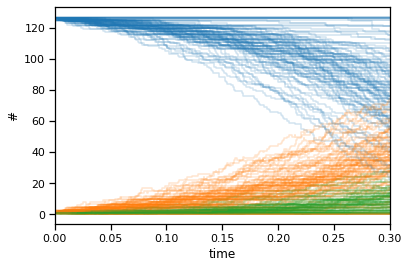

In [75]:
T = .3
s0 = np.array([127, 0, 1])
for i in range(100):
    print(i, end='\r', flush=True)
    times, states = sim(seir, T, s0)
    plt.step(times, states.T[0], color=sns.color_palette()[0], alpha=.2, label='S')
    plt.step(times, states.T[1], color=sns.color_palette()[1], alpha=.2, label='E')
    plt.step(times, states.T[2], color=sns.color_palette()[2], alpha=.2, label='I')
# plt.legend();
plt.xlabel('time'); plt.ylabel('#')
plt.xlim(0, T)

In [76]:
hist = np.array([sim_up_to(seir, .3, s0) for _ in range(1000)])#[:,2]

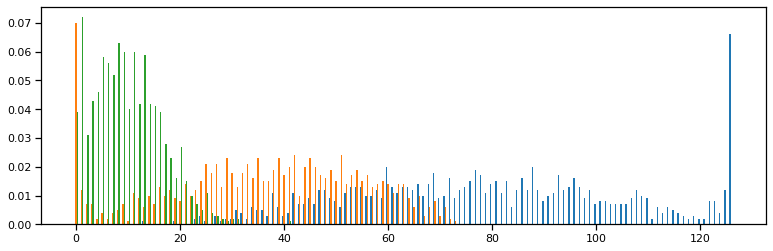

In [77]:
plt.figure(figsize=(13, 4))
plt.hist(hist, bins=hist.max(), density=True, align='left');

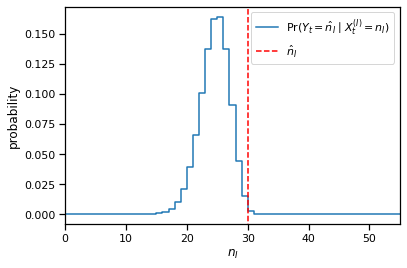

In [79]:
cap = 2 ** 7
hatnI = 30
x = np.arange(cap + 1)
measurement = np.array([sum(stats.binom(n=nI, p=.99).pmf(k)
                            * stats.binom(n=cap - nI, p=.05).pmf(hatnI - k)
                            for k in range(hatnI + 1))
                        for nI in x])
plt.step(x, measurement / measurement.sum(), label=r'$\Pr(Y_t=\hat{n}_I\mid X_t^{(I)}=n_I)$')
yl = plt.ylim()
plt.xlim(0, 55)
plt.plot([hatnI] * 2, [-1, 1], 'r--', label=r'$\hat{n}_I$')
plt.ylim(*yl)
plt.legend();
plt.xlabel(r'$n_I$'); plt.ylabel('probability');

In [84]:
# species order S, E, I
size_exp = 4
step = 2 ** size_exp
lim = cap
origins = list(itertools.product(
    list(range(0, lim, step)),
    list(range(0, lim, step)),
    list(range(0, lim, step))))
print('-> {} states'.format(len(origins)))
states = [MacroState((x1, x2, x3), (step, step, step))
          for x1, x2, x3 in origins]
ss = StateSpace(states, seir, sink=True)

-> 512 states


-> Number of states: 513
 - initial state idx: 449
-> Forwards integration
 - integrated to t=0.3


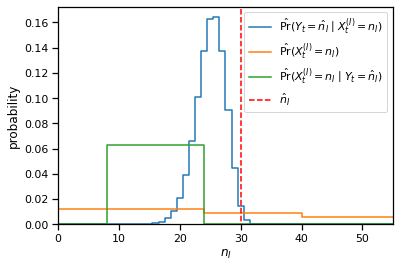

-> Backwards integration
-> Refinement
-> Truncate 384 states
-> Split 129 remaining states
-> Number of states: 1025
 - initial state idx: 969
-> Forwards integration
 - integrated to t=0.3


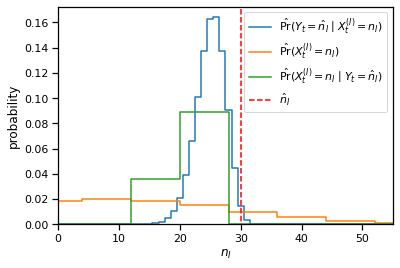

-> Backwards integration
-> Refinement
-> Truncate 656 states
-> Split 369 remaining states
-> Number of states: 2945
 - initial state idx: 2819
-> Forwards integration
 - integrated to t=0.3


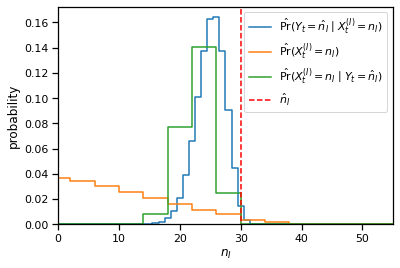

-> Backwards integration
-> Refinement
-> Truncate 2152 states
-> Split 793 remaining states
-> Number of states: 6337
 - initial state idx: 6120
-> Forwards integration


/home/jupyter-cme_lumping/.local/lib/python3.6/site-packages/scipy/integrate/_ivp/bdf.py:403: RuntimeWarning: invalid value encountered in subtract
  D[order + 2] = d - D[order + 1]


 - integrated to t=0.3


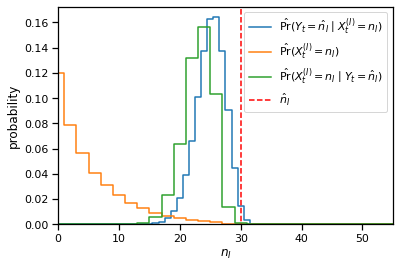

-> Backwards integration


/home/jupyter-cme_lumping/.local/lib/python3.6/site-packages/scipy/integrate/_ivp/bdf.py:403: RuntimeWarning: invalid value encountered in subtract
  D[order + 2] = d - D[order + 1]


-> Refinement
-> Truncate 4984 states
-> Split 1353 remaining states
-> Number of states: 10817
 - initial state idx: 10311
-> Forwards integration
 - integrated to t=0.3


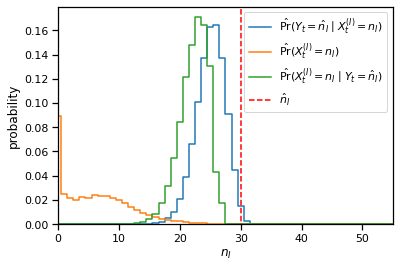

-> Backwards integration
-> Refinement
-> Done


In [85]:
s0 = MacroState((lim - 1, 0, 1), (1, 1, 1))
init_idx  = lambda: [s0 in s for s in ss.states].index(True)

t_max = .3
granularity = 50
dt = t_max / granularity
tspan = np.linspace(0, t_max, granularity)
refinement_steps = size_exp 
threshold = 1e-3 # 1e-4

y = np.zeros(len(ss))
y[init_idx()] = 1
integrator = LumpingCMEIntegrator(seir, ss, y, threshold, 0, t_max, max_step=dt / 10)
integrator.add_sink_state()


refinements_done = 0
max_cnt = step * 10
sss = []
while True:
    sss.append(len(ss))
    print('-> Number of states:', len(ss))
    print(' - initial state idx:', init_idx())
    forward  = np.zeros((granularity, len(ss)))
    backward = np.zeros((granularity, len(ss)))
    dists    = np.vstack([forward, backward])
    gc.collect()

    # forward integration
    print('-> Forwards integration')
    y_init = np.zeros(len(ss))
    y_init[init_idx()] = 1
    integrator.y = y_init
    dists[0] = y_init
    steps = 1
    t_log = 0
    while integrator.t < t_max:
        integrator.step()

        # Logging
        if integrator.t >= tspan[steps]:
            print(' - {:.2f}/{:.2f}'.format(integrator.t, t_max), end='\r', flush=True)
            assert steps <= granularity
            dists[steps] = integrator.y
            steps += 1
    print(' - integrated to t={}'.format(integrator.t))

    posterior_t = np.array([np.sum(measurement[s.origin[2]:][:s.extent[2]] * p)
                            for s, p in zip(ss.states, integrator.y)])
    posterior_t /= posterior_t.sum()
    posterior_t[0] = 0
    
    
    plt.step(x, measurement / measurement.sum(), label=r'$\hat\Pr(Y_t=\hat{n}_I\mid X_t^{(I)}=n_I)$', where='mid')
    step = ss.states[1].extent[0]
    prior = np.zeros(int(lim / step) + 1)
    for s, p in zip(ss.states, integrator.y):
        if any(x < 0 for x in s.origin):
            continue
        prior[int(s.origin[2] / step)] += p
#     prior /= prior.sum()
    plt.step(np.arange(0, lim + step, step), prior / step, label=r'$\hat\Pr(X_t^{(I)}=n_I)$', where='mid')
    post = np.zeros(int(lim / step) + 1)
    for s, p in zip(ss.states, posterior_t):
        post[int(s.origin[2] / step)] += p
    post[-1] = post[-2]
    plt.step(np.arange(0, lim + step, step), post / step, label=r'$\hat\Pr(X_t^{(I)}=n_I\mid Y_t=\hat{n}_I)$',
             where='mid')
    yl = plt.ylim()
    plt.plot([hatnI] * 2, [-1, 1], 'r--', label=r'$\hat{n}_I$')
    plt.ylim(0, yl[1]); plt.xlim(0, 55)
    plt.legend();
    plt.xlabel(r'$n_I$'); plt.ylabel('probability')
    plt.savefig('post_ref_{}_{:.2e}.pdf'.format(refinements_done, threshold))
    plt.show()
    
    # backward integration
    print('-> Backwards integration')
    integrator.switch_direction()
    integrator.y = posterior_t
    dists[-1] = posterior_t
    t_log = 0
    steps = granularity - 1
    while integrator.t < t_max:
        integrator.step()

        # Logging
        if integrator.t >= tspan[granularity - steps]:
            print(' - {:.2f}/{:.2f}'.format(integrator.t, t_max), end='\r', flush=True)
            dists[granularity + steps - 1] = integrator.y
            steps -= 1
    integrator.switch_direction()
        
    blacklist = [0, init_idx()]
    bridges = dists[:granularity] * dists[granularity:]
    bridges /= bridges.sum(1).reshape(granularity, -1)
    bridge_probs = bridges.max(0)
    print('-> Refinement')
    if refinements_done >= refinement_steps:
        break
    to_be_truncated = [i for i in range(len(ss)) if bridge_probs[i] < threshold and i not in blacklist]
    print('-> Truncate {} states'.format(len(to_be_truncated)))
    integrator.remove(to_be_truncated, redirect2sink=True)
    rem_states = len(ss)
    print('-> Split {} remaining states'.format(rem_states))
    for i in range(rem_states):
        print(' - {:.2f}%'.format(100 * (i + 1) / rem_states), end='\r', flush=True)
        ss.split(i, [0, 1, 2])

    refinements_done += 1
print('-> Done')

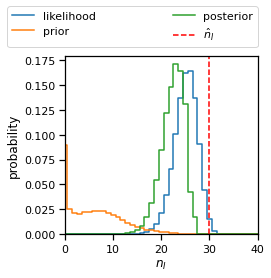

In [86]:
plt.figure(figsize=(4, 4))
plt.step(x, measurement / measurement.sum(), label=r'likelihood', where='mid')
step = ss.states[1].extent[0]
prior = np.zeros(int(lim / step) + 1)
for s, p in zip(ss.states, dists[granularity - 1]):
    if any(x < 0 for x in s.origin):
        continue
    prior[int(s.origin[2] / step)] += p
# prior /= prior.sum()
plt.step(np.arange(0, lim + step, step), prior / step, label=r'prior', where='mid')
post = np.zeros(int(lim / step) + 1)
for s, p in zip(ss.states, posterior_t):
    post[int(s.origin[2] / step)] += p
post[-1] = post[-2]
plt.step(np.arange(0, lim + step, step), post / step, label=r'posterior',
         where='mid')
yl = plt.ylim()
plt.axvline(x=hatnI,  color='r', linestyle='--', label=r'$\hat{n}_I$')
plt.ylim(0, yl[1]); plt.xlim(0, 40)
plt.legend(bbox_to_anchor=(-.3, 1.05, 1.3, .105), loc='lower left',
           ncol=2, mode="expand", borderaxespad=0.)
plt.xlabel(r'$n_I$'); plt.ylabel('probability')
plt.tight_layout()
plt.savefig('posterior.pdf'.format(refinements_done, threshold))
plt.show()

In [87]:
def dist_mat(basis, ss, dim1, dim2):
    dist = np.zeros((cap,cap))
    for s, p in zip(ss.states, basis):
        if s.origin[0] < 0: continue
        dist[s.origin[dim1], s.origin[dim2]] += p
    return dist

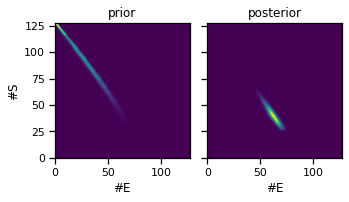

In [88]:
size = 1.1
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(size * 4.5, size * 3), sharey=True)
prior = dist_mat(dists[granularity-1], ss, 0, 1)
ax1.imshow(prior, origin='lower', vmax=.0025)
ax1.set_ylabel('#S'); ax1.set_title('prior'); ax1.set_xlabel('#E')
posterior = dist_mat(posterior_t, ss, 0, 1)
ax2.imshow(posterior, origin='lower')
ax2.set_xlabel('#E'); ax2.set_title('posterior')
plt.tight_layout()
plt.savefig('prior_posterior.pdf')

In [89]:
s, e, i, s2, e2, i2 = np.zeros(granularity), np.zeros(granularity), np.zeros(granularity), np.zeros(granularity), np.zeros(granularity), np.zeros(granularity)
sp, ep, ip, sp2, ep2, ip2 = np.zeros(granularity), np.zeros(granularity), np.zeros(granularity), np.zeros(granularity), np.zeros(granularity), np.zeros(granularity)
for k, (dist, bdist) in enumerate(zip(dists[:granularity], bridges)):
    for state, prob, bprob in zip(ss.states, dist, bdist):
        if any(x < 0 for x in state.origin):
            continue
        s[k] += state.origin[0] * prob
        e[k] += state.origin[1] * prob
        i[k] += state.origin[2] * prob
        
        
        s2[k] += state.origin[0] ** 2 * prob
        e2[k] += state.origin[1] ** 2 * prob
        i2[k] += state.origin[2] ** 2 * prob
        
        
        sp[k] += state.origin[0] * bprob
        ep[k] += state.origin[1] * bprob
        ip[k] += state.origin[2] * bprob
        
        
        sp2[k] += state.origin[0] ** 2 * bprob
        ep2[k] += state.origin[1] ** 2 * bprob
        ip2[k] += state.origin[2] ** 2 * bprob

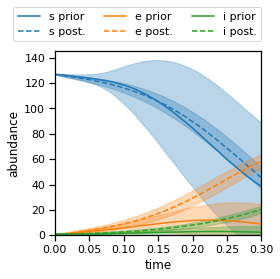

In [90]:
col_s = sns.color_palette()[0]
col_e = sns.color_palette()[1]
col_i = sns.color_palette()[2]

plt.figure(figsize=(4, 4))

tspan = np.linspace(0, t_max, granularity)

plt.plot(tspan, s, label='s prior', color=col_s)
plt.plot(tspan, sp, label='s post.', color=col_s, linestyle='--')
plt.plot(tspan, e, label='e prior', color=col_e)
plt.plot(tspan, ep, label='e post.', color=col_e, linestyle='--')
plt.plot(tspan, i, label='i prior', color=col_i)
plt.plot(tspan, ip, label='i post.', color=col_i, linestyle='--')

plt.fill_between(tspan,
                 s - 1. * np.sqrt(s2 - s ** 2),
                 s + 1. * np.sqrt(s2 - s ** 2),
                 alpha=.3, color=col_s)
plt.fill_between(tspan,
                 e - 1. * np.sqrt(e2 - e ** 2),
                 e + 1. * np.sqrt(e2 - e ** 2),
                 alpha=.3, color=col_e)
plt.fill_between(tspan,
                 i - 1. * np.sqrt(i2 - i ** 2),
                 i + 1. * np.sqrt(i2 - i ** 2),
                 alpha=.3, color=col_i)


plt.fill_between(tspan,
                 sp - 1. * np.sqrt(sp2 - sp ** 2),
                 sp + 1. * np.sqrt(sp2 - sp ** 2),
                 alpha=.3, color=col_s)
plt.fill_between(tspan,
                 ep - 1. * np.sqrt(ep2 - ep ** 2),
                 ep + 1. * np.sqrt(ep2 - ep ** 2),
                 alpha=.3, color=col_e)
plt.fill_between(tspan,
                 ip - 1. * np.sqrt(ip2 - ip ** 2),
                 ip + 1. * np.sqrt(ip2 - ip ** 2),
                 alpha=.3, color=col_i)

plt.ylim(0, None)
plt.xlim(0, t_max)
plt.legend(bbox_to_anchor=(-0.2, 1.05, 1.2, .105), loc='lower left',
           ncol=3, borderaxespad=0., mode='expand')
plt.xlabel('time')
plt.ylabel('abundance')
plt.tight_layout()
plt.savefig('seir_prior_posterior.pdf')

In [91]:
i1, i2 = 1, 0
im2 = np.zeros((128, 128))
for s in ss.states:
    im2[s.origin[i1], s.origin[i2]] = 1

(0.0, 130.0)

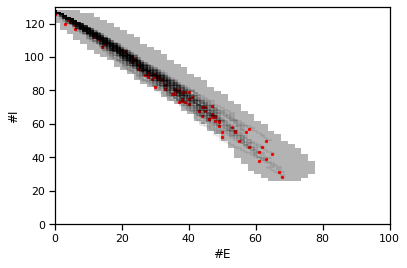

In [92]:
s0 = np.array([127, 0, 1])
for i in range(100):
    print(i, end='\r', flush=True)
    times, states = sim(seir, 0.3, s0)
    plt.scatter(states[-1][i1], states[-1][i2], c='r', marker='o', s=5)
    plt.step(states.T[i1] + .5, states.T[i2] + .5, alpha=.1, color='k')
plt.xlabel('#E'); plt.ylabel('#I')
# plt.imshow(im.T, origin='lower', cmap="cubehelix_r", interpolation='none', alpha=.3)
ax = plt.imshow(im2.T, origin='lower', cmap="cubehelix_r", interpolation='none', alpha=.3, aspect='auto')
plt.xlim(0, 100)
plt.ylim(0, 130)